In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 276)
(4629816, 8)
validation
(621056, 276)
(621056, 8)
test
(624904, 276)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 973704 (3.71 MB)


Trainable params: 973704 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:50 - loss: 2.1544 - STD: 0.0545 - MAE: 0.2170

  6/463 [..............................] - ETA: 5s - loss: 2.0858 - STD: 0.0433 - MAE: 0.2167  

 11/463 [..............................] - ETA: 4s - loss: 2.0733 - STD: 0.0396 - MAE: 0.2167

 16/463 [>.............................] - ETA: 4s - loss: 2.0693 - STD: 0.0377 - MAE: 0.2168

 21/463 [>.............................] - ETA: 4s - loss: 2.0655 - STD: 0.0363 - MAE: 0.2168

 26/463 [>.............................] - ETA: 4s - loss: 2.0631 - STD: 0.0361 - MAE: 0.2167

 31/463 [=>............................] - ETA: 4s - loss: 2.0613 - STD: 0.0351 - MAE: 0.2167

 36/463 [=>............................] - ETA: 4s - loss: 2.0600 - STD: 0.0347 - MAE: 0.2167

 41/463 [=>............................] - ETA: 4s - loss: 2.0583 - STD: 0.0345 - MAE: 0.2167

 46/463 [=>............................] - ETA: 4s - loss: 2.0572 - STD: 0.0341 - MAE: 0.2167

 51/463 [==>...........................] - ETA: 4s - loss: 2.0558 - STD: 0.0339 - MAE: 0.2167

 56/463 [==>...........................] - ETA: 4s - loss: 2.0536 - STD: 0.0340 - MAE: 0.2166

 61/463 [==>...........................] - ETA: 4s - loss: 2.0506 - STD: 0.0342 - MAE: 0.2165

 66/463 [===>..........................] - ETA: 4s - loss: 2.0470 - STD: 0.0351 - MAE: 0.2163

 71/463 [===>..........................] - ETA: 4s - loss: 2.0428 - STD: 0.0364 - MAE: 0.2160

 76/463 [===>..........................] - ETA: 4s - loss: 2.0380 - STD: 0.0377 - MAE: 0.2158

 81/463 [====>.........................] - ETA: 4s - loss: 2.0326 - STD: 0.0390 - MAE: 0.2155

 86/463 [====>.........................] - ETA: 4s - loss: 2.0268 - STD: 0.0402 - MAE: 0.2152

 91/463 [====>.........................] - ETA: 4s - loss: 2.0206 - STD: 0.0415 - MAE: 0.2149

 96/463 [=====>........................] - ETA: 3s - loss: 2.0142 - STD: 0.0430 - MAE: 0.2146

101/463 [=====>........................] - ETA: 3s - loss: 2.0073 - STD: 0.0444 - MAE: 0.2142

105/463 [=====>........................] - ETA: 6s - loss: 2.0019 - STD: 0.0455 - MAE: 0.2139

110/463 [======>.......................] - ETA: 6s - loss: 1.9952 - STD: 0.0470 - MAE: 0.2136

115/463 [======>.......................] - ETA: 5s - loss: 1.9887 - STD: 0.0485 - MAE: 0.2132

120/463 [======>.......................] - ETA: 5s - loss: 1.9826 - STD: 0.0498 - MAE: 0.2129

125/463 [=======>......................] - ETA: 5s - loss: 1.9768 - STD: 0.0511 - MAE: 0.2126

130/463 [=======>......................] - ETA: 5s - loss: 1.9710 - STD: 0.0523 - MAE: 0.2122

135/463 [=======>......................] - ETA: 5s - loss: 1.9654 - STD: 0.0535 - MAE: 0.2119

140/463 [========>.....................] - ETA: 5s - loss: 1.9601 - STD: 0.0545 - MAE: 0.2117

145/463 [========>.....................] - ETA: 5s - loss: 1.9548 - STD: 0.0556 - MAE: 0.2114

150/463 [========>.....................] - ETA: 4s - loss: 1.9499 - STD: 0.0566 - MAE: 0.2111

155/463 [=========>....................] - ETA: 4s - loss: 1.9450 - STD: 0.0576 - MAE: 0.2108

160/463 [=========>....................] - ETA: 4s - loss: 1.9402 - STD: 0.0585 - MAE: 0.2105

165/463 [=========>....................] - ETA: 4s - loss: 1.9355 - STD: 0.0595 - MAE: 0.2102

170/463 [==========>...................] - ETA: 4s - loss: 1.9306 - STD: 0.0604 - MAE: 0.2099

175/463 [==========>...................] - ETA: 4s - loss: 1.9262 - STD: 0.0614 - MAE: 0.2096

180/463 [==========>...................] - ETA: 4s - loss: 1.9218 - STD: 0.0624 - MAE: 0.2093

185/463 [==========>...................] - ETA: 4s - loss: 1.9175 - STD: 0.0633 - MAE: 0.2091

190/463 [===========>..................] - ETA: 3s - loss: 1.9133 - STD: 0.0642 - MAE: 0.2088

195/463 [===========>..................] - ETA: 3s - loss: 1.9094 - STD: 0.0651 - MAE: 0.2085

200/463 [===========>..................] - ETA: 3s - loss: 1.9056 - STD: 0.0659 - MAE: 0.2083

205/463 [============>.................] - ETA: 3s - loss: 1.9019 - STD: 0.0667 - MAE: 0.2080

210/463 [============>.................] - ETA: 3s - loss: 1.8983 - STD: 0.0675 - MAE: 0.2078

215/463 [============>.................] - ETA: 3s - loss: 1.8948 - STD: 0.0683 - MAE: 0.2075

220/463 [=============>................] - ETA: 3s - loss: 1.8915 - STD: 0.0690 - MAE: 0.2073

225/463 [=============>................] - ETA: 3s - loss: 1.8883 - STD: 0.0697 - MAE: 0.2071

230/463 [=============>................] - ETA: 3s - loss: 1.8850 - STD: 0.0705 - MAE: 0.2069

235/463 [==============>...............] - ETA: 3s - loss: 1.8820 - STD: 0.0712 - MAE: 0.2067

240/463 [==============>...............] - ETA: 3s - loss: 1.8789 - STD: 0.0718 - MAE: 0.2065

245/463 [==============>...............] - ETA: 2s - loss: 1.8758 - STD: 0.0725 - MAE: 0.2063

250/463 [===============>..............] - ETA: 2s - loss: 1.8730 - STD: 0.0731 - MAE: 0.2061

255/463 [===============>..............] - ETA: 2s - loss: 1.8703 - STD: 0.0737 - MAE: 0.2059

260/463 [===============>..............] - ETA: 2s - loss: 1.8674 - STD: 0.0743 - MAE: 0.2057

265/463 [================>.............] - ETA: 2s - loss: 1.8647 - STD: 0.0749 - MAE: 0.2055

270/463 [================>.............] - ETA: 2s - loss: 1.8621 - STD: 0.0755 - MAE: 0.2053

275/463 [================>.............] - ETA: 2s - loss: 1.8596 - STD: 0.0760 - MAE: 0.2052

280/463 [=================>............] - ETA: 2s - loss: 1.8571 - STD: 0.0765 - MAE: 0.2050

285/463 [=================>............] - ETA: 2s - loss: 1.8546 - STD: 0.0770 - MAE: 0.2048

290/463 [=================>............] - ETA: 2s - loss: 1.8523 - STD: 0.0776 - MAE: 0.2047

295/463 [==================>...........] - ETA: 2s - loss: 1.8499 - STD: 0.0780 - MAE: 0.2045

300/463 [==================>...........] - ETA: 2s - loss: 1.8474 - STD: 0.0785 - MAE: 0.2044

305/463 [==================>...........] - ETA: 2s - loss: 1.8451 - STD: 0.0790 - MAE: 0.2042

310/463 [===================>..........] - ETA: 2s - loss: 1.8428 - STD: 0.0795 - MAE: 0.2040

315/463 [===================>..........] - ETA: 1s - loss: 1.8404 - STD: 0.0800 - MAE: 0.2039

320/463 [===================>..........] - ETA: 1s - loss: 1.8382 - STD: 0.0804 - MAE: 0.2037

325/463 [====================>.........] - ETA: 1s - loss: 1.8359 - STD: 0.0809 - MAE: 0.2036

330/463 [====================>.........] - ETA: 1s - loss: 1.8339 - STD: 0.0814 - MAE: 0.2034

335/463 [====================>.........] - ETA: 1s - loss: 1.8319 - STD: 0.0818 - MAE: 0.2033

340/463 [=====================>........] - ETA: 1s - loss: 1.8299 - STD: 0.0823 - MAE: 0.2031

345/463 [=====================>........] - ETA: 1s - loss: 1.8279 - STD: 0.0827 - MAE: 0.2030

350/463 [=====================>........] - ETA: 1s - loss: 1.8259 - STD: 0.0831 - MAE: 0.2028

355/463 [======================>.......] - ETA: 1s - loss: 1.8240 - STD: 0.0835 - MAE: 0.2027

360/463 [======================>.......] - ETA: 1s - loss: 1.8222 - STD: 0.0839 - MAE: 0.2026

365/463 [======================>.......] - ETA: 1s - loss: 1.8203 - STD: 0.0843 - MAE: 0.2024

370/463 [======================>.......] - ETA: 1s - loss: 1.8185 - STD: 0.0847 - MAE: 0.2023

375/463 [=======================>......] - ETA: 1s - loss: 1.8167 - STD: 0.0851 - MAE: 0.2022

380/463 [=======================>......] - ETA: 1s - loss: 1.8150 - STD: 0.0854 - MAE: 0.2021

385/463 [=======================>......] - ETA: 0s - loss: 1.8132 - STD: 0.0858 - MAE: 0.2019

390/463 [========================>.....] - ETA: 0s - loss: 1.8115 - STD: 0.0862 - MAE: 0.2018

395/463 [========================>.....] - ETA: 0s - loss: 1.8098 - STD: 0.0865 - MAE: 0.2017

400/463 [========================>.....] - ETA: 0s - loss: 1.8082 - STD: 0.0868 - MAE: 0.2016

405/463 [=========================>....] - ETA: 0s - loss: 1.8066 - STD: 0.0872 - MAE: 0.2015

410/463 [=========================>....] - ETA: 0s - loss: 1.8050 - STD: 0.0875 - MAE: 0.2013

412/463 [=========================>....] - ETA: 0s - loss: 1.8043 - STD: 0.0877 - MAE: 0.2013

417/463 [==========================>...] - ETA: 0s - loss: 1.8028 - STD: 0.0880 - MAE: 0.2012

422/463 [==========================>...] - ETA: 0s - loss: 1.8012 - STD: 0.0883 - MAE: 0.2011

427/463 [==========================>...] - ETA: 0s - loss: 1.7996 - STD: 0.0886 - MAE: 0.2010

432/463 [==========================>...] - ETA: 0s - loss: 1.7981 - STD: 0.0889 - MAE: 0.2009

437/463 [===========================>..] - ETA: 0s - loss: 1.7965 - STD: 0.0892 - MAE: 0.2007

442/463 [===========================>..] - ETA: 0s - loss: 1.7951 - STD: 0.0895 - MAE: 0.2006

447/463 [===========================>..] - ETA: 0s - loss: 1.7936 - STD: 0.0898 - MAE: 0.2005

452/463 [============================>.] - ETA: 0s - loss: 1.7922 - STD: 0.0901 - MAE: 0.2004

457/463 [============================>.] - ETA: 0s - loss: 1.7908 - STD: 0.0904 - MAE: 0.2003

462/463 [============================>.] - ETA: 0s - loss: 1.7894 - STD: 0.0907 - MAE: 0.2002

463/463 [==============================] - 8s 15ms/step - loss: 1.7891 - STD: 0.0908 - MAE: 0.2002 - val_loss: 1.7051 - val_STD: 0.1157 - val_MAE: 0.1919


Epoch 2/10000


  1/463 [..............................] - ETA: 15s - loss: 1.6540 - STD: 0.1187 - MAE: 0.1902

  6/463 [..............................] - ETA: 5s - loss: 1.6592 - STD: 0.1160 - MAE: 0.1912 

 11/463 [..............................] - ETA: 5s - loss: 1.6590 - STD: 0.1164 - MAE: 0.1911

 16/463 [>.............................] - ETA: 5s - loss: 1.6595 - STD: 0.1166 - MAE: 0.1911

 21/463 [>.............................] - ETA: 5s - loss: 1.6585 - STD: 0.1167 - MAE: 0.1910

 26/463 [>.............................] - ETA: 4s - loss: 1.6583 - STD: 0.1166 - MAE: 0.1910

 31/463 [=>............................] - ETA: 4s - loss: 1.6577 - STD: 0.1166 - MAE: 0.1910

 36/463 [=>............................] - ETA: 4s - loss: 1.6571 - STD: 0.1168 - MAE: 0.1910

 41/463 [=>............................] - ETA: 4s - loss: 1.6567 - STD: 0.1169 - MAE: 0.1909

 46/463 [=>............................] - ETA: 4s - loss: 1.6558 - STD: 0.1170 - MAE: 0.1908

 51/463 [==>...........................] - ETA: 4s - loss: 1.6553 - STD: 0.1171 - MAE: 0.1908

 56/463 [==>...........................] - ETA: 4s - loss: 1.6546 - STD: 0.1172 - MAE: 0.1908

 61/463 [==>...........................] - ETA: 4s - loss: 1.6543 - STD: 0.1173 - MAE: 0.1907

 66/463 [===>..........................] - ETA: 4s - loss: 1.6542 - STD: 0.1173 - MAE: 0.1907

 71/463 [===>..........................] - ETA: 4s - loss: 1.6540 - STD: 0.1173 - MAE: 0.1907

 76/463 [===>..........................] - ETA: 4s - loss: 1.6540 - STD: 0.1174 - MAE: 0.1907

 81/463 [====>.........................] - ETA: 4s - loss: 1.6535 - STD: 0.1174 - MAE: 0.1907

 86/463 [====>.........................] - ETA: 4s - loss: 1.6536 - STD: 0.1175 - MAE: 0.1907

 91/463 [====>.........................] - ETA: 4s - loss: 1.6530 - STD: 0.1175 - MAE: 0.1906

 96/463 [=====>........................] - ETA: 4s - loss: 1.6526 - STD: 0.1175 - MAE: 0.1906

101/463 [=====>........................] - ETA: 4s - loss: 1.6525 - STD: 0.1177 - MAE: 0.1906

106/463 [=====>........................] - ETA: 3s - loss: 1.6526 - STD: 0.1177 - MAE: 0.1906

111/463 [======>.......................] - ETA: 3s - loss: 1.6525 - STD: 0.1177 - MAE: 0.1906

116/463 [======>.......................] - ETA: 3s - loss: 1.6525 - STD: 0.1178 - MAE: 0.1906

121/463 [======>.......................] - ETA: 3s - loss: 1.6525 - STD: 0.1177 - MAE: 0.1906

126/463 [=======>......................] - ETA: 3s - loss: 1.6521 - STD: 0.1178 - MAE: 0.1905

131/463 [=======>......................] - ETA: 3s - loss: 1.6519 - STD: 0.1179 - MAE: 0.1905

136/463 [=======>......................] - ETA: 3s - loss: 1.6516 - STD: 0.1179 - MAE: 0.1905

141/463 [========>.....................] - ETA: 3s - loss: 1.6514 - STD: 0.1179 - MAE: 0.1905

146/463 [========>.....................] - ETA: 3s - loss: 1.6511 - STD: 0.1180 - MAE: 0.1904

151/463 [========>.....................] - ETA: 3s - loss: 1.6507 - STD: 0.1180 - MAE: 0.1904

156/463 [=========>....................] - ETA: 3s - loss: 1.6503 - STD: 0.1180 - MAE: 0.1904

161/463 [=========>....................] - ETA: 3s - loss: 1.6500 - STD: 0.1181 - MAE: 0.1904

166/463 [=========>....................] - ETA: 3s - loss: 1.6498 - STD: 0.1182 - MAE: 0.1904

171/463 [==========>...................] - ETA: 3s - loss: 1.6493 - STD: 0.1182 - MAE: 0.1903

176/463 [==========>...................] - ETA: 3s - loss: 1.6491 - STD: 0.1182 - MAE: 0.1903

181/463 [==========>...................] - ETA: 3s - loss: 1.6488 - STD: 0.1183 - MAE: 0.1903

186/463 [===========>..................] - ETA: 3s - loss: 1.6487 - STD: 0.1183 - MAE: 0.1903

191/463 [===========>..................] - ETA: 3s - loss: 1.6483 - STD: 0.1184 - MAE: 0.1902

196/463 [===========>..................] - ETA: 2s - loss: 1.6479 - STD: 0.1184 - MAE: 0.1902

201/463 [============>.................] - ETA: 2s - loss: 1.6476 - STD: 0.1185 - MAE: 0.1902

206/463 [============>.................] - ETA: 2s - loss: 1.6474 - STD: 0.1185 - MAE: 0.1902

211/463 [============>.................] - ETA: 2s - loss: 1.6471 - STD: 0.1185 - MAE: 0.1902

216/463 [============>.................] - ETA: 2s - loss: 1.6469 - STD: 0.1186 - MAE: 0.1901

221/463 [=============>................] - ETA: 2s - loss: 1.6465 - STD: 0.1186 - MAE: 0.1901

226/463 [=============>................] - ETA: 2s - loss: 1.6462 - STD: 0.1187 - MAE: 0.1901

231/463 [=============>................] - ETA: 2s - loss: 1.6459 - STD: 0.1188 - MAE: 0.1901

236/463 [==============>...............] - ETA: 2s - loss: 1.6456 - STD: 0.1188 - MAE: 0.1900

241/463 [==============>...............] - ETA: 2s - loss: 1.6452 - STD: 0.1188 - MAE: 0.1900

246/463 [==============>...............] - ETA: 2s - loss: 1.6449 - STD: 0.1189 - MAE: 0.1900

251/463 [===============>..............] - ETA: 2s - loss: 1.6446 - STD: 0.1189 - MAE: 0.1900

256/463 [===============>..............] - ETA: 2s - loss: 1.6442 - STD: 0.1190 - MAE: 0.1899

261/463 [===============>..............] - ETA: 2s - loss: 1.6440 - STD: 0.1190 - MAE: 0.1899

266/463 [================>.............] - ETA: 2s - loss: 1.6438 - STD: 0.1190 - MAE: 0.1899

271/463 [================>.............] - ETA: 2s - loss: 1.6435 - STD: 0.1191 - MAE: 0.1899

276/463 [================>.............] - ETA: 2s - loss: 1.6431 - STD: 0.1191 - MAE: 0.1899

281/463 [=================>............] - ETA: 2s - loss: 1.6428 - STD: 0.1192 - MAE: 0.1898

286/463 [=================>............] - ETA: 1s - loss: 1.6425 - STD: 0.1192 - MAE: 0.1898

291/463 [=================>............] - ETA: 1s - loss: 1.6424 - STD: 0.1193 - MAE: 0.1898

296/463 [==================>...........] - ETA: 1s - loss: 1.6422 - STD: 0.1193 - MAE: 0.1898

301/463 [==================>...........] - ETA: 1s - loss: 1.6419 - STD: 0.1194 - MAE: 0.1898

306/463 [==================>...........] - ETA: 1s - loss: 1.6416 - STD: 0.1194 - MAE: 0.1898

311/463 [===================>..........] - ETA: 1s - loss: 1.6414 - STD: 0.1194 - MAE: 0.1897

316/463 [===================>..........] - ETA: 1s - loss: 1.6412 - STD: 0.1195 - MAE: 0.1897

321/463 [===================>..........] - ETA: 1s - loss: 1.6411 - STD: 0.1195 - MAE: 0.1897

326/463 [====================>.........] - ETA: 1s - loss: 1.6408 - STD: 0.1195 - MAE: 0.1897

331/463 [====================>.........] - ETA: 1s - loss: 1.6406 - STD: 0.1196 - MAE: 0.1897

336/463 [====================>.........] - ETA: 1s - loss: 1.6403 - STD: 0.1196 - MAE: 0.1896

341/463 [=====================>........] - ETA: 1s - loss: 1.6400 - STD: 0.1197 - MAE: 0.1896

346/463 [=====================>........] - ETA: 1s - loss: 1.6398 - STD: 0.1197 - MAE: 0.1896

351/463 [=====================>........] - ETA: 1s - loss: 1.6396 - STD: 0.1197 - MAE: 0.1896

356/463 [======================>.......] - ETA: 1s - loss: 1.6395 - STD: 0.1198 - MAE: 0.1896

361/463 [======================>.......] - ETA: 1s - loss: 1.6393 - STD: 0.1198 - MAE: 0.1896

366/463 [======================>.......] - ETA: 1s - loss: 1.6389 - STD: 0.1199 - MAE: 0.1895

371/463 [=======================>......] - ETA: 1s - loss: 1.6387 - STD: 0.1199 - MAE: 0.1895

376/463 [=======================>......] - ETA: 0s - loss: 1.6385 - STD: 0.1199 - MAE: 0.1895

381/463 [=======================>......] - ETA: 0s - loss: 1.6384 - STD: 0.1200 - MAE: 0.1895

386/463 [========================>.....] - ETA: 0s - loss: 1.6382 - STD: 0.1200 - MAE: 0.1895

391/463 [========================>.....] - ETA: 0s - loss: 1.6380 - STD: 0.1200 - MAE: 0.1894

396/463 [========================>.....] - ETA: 0s - loss: 1.6378 - STD: 0.1201 - MAE: 0.1894

401/463 [========================>.....] - ETA: 0s - loss: 1.6376 - STD: 0.1201 - MAE: 0.1894

406/463 [=========================>....] - ETA: 0s - loss: 1.6375 - STD: 0.1201 - MAE: 0.1894

411/463 [=========================>....] - ETA: 0s - loss: 1.6373 - STD: 0.1202 - MAE: 0.1894

416/463 [=========================>....] - ETA: 0s - loss: 1.6370 - STD: 0.1202 - MAE: 0.1894

421/463 [==========================>...] - ETA: 0s - loss: 1.6368 - STD: 0.1202 - MAE: 0.1894

426/463 [==========================>...] - ETA: 0s - loss: 1.6365 - STD: 0.1203 - MAE: 0.1893

431/463 [==========================>...] - ETA: 0s - loss: 1.6363 - STD: 0.1203 - MAE: 0.1893

436/463 [===========================>..] - ETA: 0s - loss: 1.6362 - STD: 0.1204 - MAE: 0.1893

441/463 [===========================>..] - ETA: 0s - loss: 1.6362 - STD: 0.1204 - MAE: 0.1893

446/463 [===========================>..] - ETA: 0s - loss: 1.6360 - STD: 0.1204 - MAE: 0.1893

451/463 [============================>.] - ETA: 0s - loss: 1.6357 - STD: 0.1205 - MAE: 0.1893

456/463 [============================>.] - ETA: 0s - loss: 1.6355 - STD: 0.1205 - MAE: 0.1892

461/463 [============================>.] - ETA: 0s - loss: 1.6352 - STD: 0.1205 - MAE: 0.1892

463/463 [==============================] - 6s 12ms/step - loss: 1.6351 - STD: 0.1205 - MAE: 0.1892 - val_loss: 1.6794 - val_STD: 0.1176 - val_MAE: 0.1906


Epoch 3/10000


  1/463 [..............................] - ETA: 13s - loss: 1.6193 - STD: 0.1231 - MAE: 0.1882

  5/463 [..............................] - ETA: 6s - loss: 1.6205 - STD: 0.1233 - MAE: 0.1880 

 10/463 [..............................] - ETA: 5s - loss: 1.6215 - STD: 0.1236 - MAE: 0.1880

 15/463 [..............................] - ETA: 5s - loss: 1.6221 - STD: 0.1237 - MAE: 0.1880

 20/463 [>.............................] - ETA: 4s - loss: 1.6220 - STD: 0.1235 - MAE: 0.1880

 25/463 [>.............................] - ETA: 4s - loss: 1.6212 - STD: 0.1236 - MAE: 0.1879

 30/463 [>.............................] - ETA: 4s - loss: 1.6195 - STD: 0.1236 - MAE: 0.1878

 35/463 [=>............................] - ETA: 4s - loss: 1.6197 - STD: 0.1235 - MAE: 0.1879

 40/463 [=>............................] - ETA: 4s - loss: 1.6189 - STD: 0.1236 - MAE: 0.1878

 45/463 [=>............................] - ETA: 4s - loss: 1.6187 - STD: 0.1236 - MAE: 0.1878

 50/463 [==>...........................] - ETA: 4s - loss: 1.6187 - STD: 0.1236 - MAE: 0.1878

 55/463 [==>...........................] - ETA: 4s - loss: 1.6182 - STD: 0.1235 - MAE: 0.1879

 60/463 [==>...........................] - ETA: 4s - loss: 1.6182 - STD: 0.1236 - MAE: 0.1878

 65/463 [===>..........................] - ETA: 4s - loss: 1.6178 - STD: 0.1236 - MAE: 0.1878

 70/463 [===>..........................] - ETA: 4s - loss: 1.6173 - STD: 0.1236 - MAE: 0.1878

 75/463 [===>..........................] - ETA: 4s - loss: 1.6169 - STD: 0.1236 - MAE: 0.1878

 80/463 [====>.........................] - ETA: 4s - loss: 1.6164 - STD: 0.1237 - MAE: 0.1878

 85/463 [====>.........................] - ETA: 4s - loss: 1.6158 - STD: 0.1237 - MAE: 0.1877

 90/463 [====>.........................] - ETA: 4s - loss: 1.6156 - STD: 0.1238 - MAE: 0.1877

 95/463 [=====>........................] - ETA: 3s - loss: 1.6152 - STD: 0.1239 - MAE: 0.1876

100/463 [=====>........................] - ETA: 3s - loss: 1.6153 - STD: 0.1239 - MAE: 0.1876

105/463 [=====>........................] - ETA: 3s - loss: 1.6157 - STD: 0.1241 - MAE: 0.1876

110/463 [======>.......................] - ETA: 3s - loss: 1.6154 - STD: 0.1240 - MAE: 0.1876

115/463 [======>.......................] - ETA: 3s - loss: 1.6149 - STD: 0.1240 - MAE: 0.1876

120/463 [======>.......................] - ETA: 3s - loss: 1.6146 - STD: 0.1241 - MAE: 0.1876

125/463 [=======>......................] - ETA: 3s - loss: 1.6142 - STD: 0.1240 - MAE: 0.1876

130/463 [=======>......................] - ETA: 3s - loss: 1.6138 - STD: 0.1241 - MAE: 0.1875

135/463 [=======>......................] - ETA: 3s - loss: 1.6134 - STD: 0.1242 - MAE: 0.1875

140/463 [========>.....................] - ETA: 3s - loss: 1.6132 - STD: 0.1242 - MAE: 0.1875

145/463 [========>.....................] - ETA: 3s - loss: 1.6131 - STD: 0.1243 - MAE: 0.1875

150/463 [========>.....................] - ETA: 3s - loss: 1.6128 - STD: 0.1243 - MAE: 0.1875

155/463 [=========>....................] - ETA: 3s - loss: 1.6127 - STD: 0.1243 - MAE: 0.1874

160/463 [=========>....................] - ETA: 3s - loss: 1.6127 - STD: 0.1243 - MAE: 0.1874

165/463 [=========>....................] - ETA: 3s - loss: 1.6125 - STD: 0.1243 - MAE: 0.1874

170/463 [==========>...................] - ETA: 3s - loss: 1.6122 - STD: 0.1244 - MAE: 0.1874

175/463 [==========>...................] - ETA: 3s - loss: 1.6119 - STD: 0.1244 - MAE: 0.1874

180/463 [==========>...................] - ETA: 3s - loss: 1.6117 - STD: 0.1244 - MAE: 0.1874

185/463 [==========>...................] - ETA: 2s - loss: 1.6115 - STD: 0.1245 - MAE: 0.1874

190/463 [===========>..................] - ETA: 2s - loss: 1.6113 - STD: 0.1245 - MAE: 0.1874

195/463 [===========>..................] - ETA: 2s - loss: 1.6110 - STD: 0.1245 - MAE: 0.1873

200/463 [===========>..................] - ETA: 2s - loss: 1.6108 - STD: 0.1245 - MAE: 0.1873

205/463 [============>.................] - ETA: 2s - loss: 1.6105 - STD: 0.1246 - MAE: 0.1873

210/463 [============>.................] - ETA: 2s - loss: 1.6103 - STD: 0.1246 - MAE: 0.1873

215/463 [============>.................] - ETA: 2s - loss: 1.6099 - STD: 0.1246 - MAE: 0.1873

220/463 [=============>................] - ETA: 2s - loss: 1.6096 - STD: 0.1247 - MAE: 0.1872

225/463 [=============>................] - ETA: 2s - loss: 1.6093 - STD: 0.1247 - MAE: 0.1872

230/463 [=============>................] - ETA: 2s - loss: 1.6093 - STD: 0.1247 - MAE: 0.1872

235/463 [==============>...............] - ETA: 2s - loss: 1.6092 - STD: 0.1248 - MAE: 0.1872

240/463 [==============>...............] - ETA: 2s - loss: 1.6091 - STD: 0.1248 - MAE: 0.1872

245/463 [==============>...............] - ETA: 2s - loss: 1.6091 - STD: 0.1248 - MAE: 0.1872

250/463 [===============>..............] - ETA: 2s - loss: 1.6089 - STD: 0.1248 - MAE: 0.1872

255/463 [===============>..............] - ETA: 2s - loss: 1.6087 - STD: 0.1249 - MAE: 0.1872

260/463 [===============>..............] - ETA: 2s - loss: 1.6085 - STD: 0.1249 - MAE: 0.1871

265/463 [================>.............] - ETA: 2s - loss: 1.6085 - STD: 0.1249 - MAE: 0.1871

270/463 [================>.............] - ETA: 2s - loss: 1.6083 - STD: 0.1249 - MAE: 0.1871

275/463 [================>.............] - ETA: 2s - loss: 1.6082 - STD: 0.1249 - MAE: 0.1871

280/463 [=================>............] - ETA: 1s - loss: 1.6080 - STD: 0.1249 - MAE: 0.1871

285/463 [=================>............] - ETA: 1s - loss: 1.6079 - STD: 0.1250 - MAE: 0.1871

290/463 [=================>............] - ETA: 1s - loss: 1.6078 - STD: 0.1250 - MAE: 0.1871

295/463 [==================>...........] - ETA: 1s - loss: 1.6077 - STD: 0.1250 - MAE: 0.1871

300/463 [==================>...........] - ETA: 1s - loss: 1.6078 - STD: 0.1250 - MAE: 0.1871

305/463 [==================>...........] - ETA: 1s - loss: 1.6080 - STD: 0.1250 - MAE: 0.1871

310/463 [===================>..........] - ETA: 1s - loss: 1.6081 - STD: 0.1250 - MAE: 0.1871

315/463 [===================>..........] - ETA: 1s - loss: 1.6081 - STD: 0.1250 - MAE: 0.1871

320/463 [===================>..........] - ETA: 1s - loss: 1.6080 - STD: 0.1250 - MAE: 0.1871

325/463 [====================>.........] - ETA: 1s - loss: 1.6080 - STD: 0.1250 - MAE: 0.1871

330/463 [====================>.........] - ETA: 1s - loss: 1.6078 - STD: 0.1251 - MAE: 0.1871

335/463 [====================>.........] - ETA: 1s - loss: 1.6077 - STD: 0.1251 - MAE: 0.1871

340/463 [=====================>........] - ETA: 1s - loss: 1.6077 - STD: 0.1251 - MAE: 0.1871

345/463 [=====================>........] - ETA: 1s - loss: 1.6076 - STD: 0.1251 - MAE: 0.1871

350/463 [=====================>........] - ETA: 1s - loss: 1.6075 - STD: 0.1251 - MAE: 0.1871

355/463 [======================>.......] - ETA: 1s - loss: 1.6073 - STD: 0.1251 - MAE: 0.1870

360/463 [======================>.......] - ETA: 1s - loss: 1.6071 - STD: 0.1252 - MAE: 0.1870

365/463 [======================>.......] - ETA: 1s - loss: 1.6070 - STD: 0.1252 - MAE: 0.1870

370/463 [======================>.......] - ETA: 1s - loss: 1.6068 - STD: 0.1252 - MAE: 0.1870

375/463 [=======================>......] - ETA: 0s - loss: 1.6066 - STD: 0.1252 - MAE: 0.1870

380/463 [=======================>......] - ETA: 0s - loss: 1.6065 - STD: 0.1252 - MAE: 0.1870

385/463 [=======================>......] - ETA: 0s - loss: 1.6063 - STD: 0.1252 - MAE: 0.1870

390/463 [========================>.....] - ETA: 0s - loss: 1.6061 - STD: 0.1253 - MAE: 0.1870

395/463 [========================>.....] - ETA: 0s - loss: 1.6060 - STD: 0.1253 - MAE: 0.1870

400/463 [========================>.....] - ETA: 0s - loss: 1.6060 - STD: 0.1253 - MAE: 0.1870

405/463 [=========================>....] - ETA: 0s - loss: 1.6059 - STD: 0.1253 - MAE: 0.1869

410/463 [=========================>....] - ETA: 0s - loss: 1.6059 - STD: 0.1253 - MAE: 0.1869

415/463 [=========================>....] - ETA: 0s - loss: 1.6058 - STD: 0.1253 - MAE: 0.1869

420/463 [==========================>...] - ETA: 0s - loss: 1.6057 - STD: 0.1254 - MAE: 0.1869

425/463 [==========================>...] - ETA: 0s - loss: 1.6057 - STD: 0.1254 - MAE: 0.1869

430/463 [==========================>...] - ETA: 0s - loss: 1.6056 - STD: 0.1254 - MAE: 0.1869

435/463 [===========================>..] - ETA: 0s - loss: 1.6055 - STD: 0.1254 - MAE: 0.1869

440/463 [===========================>..] - ETA: 0s - loss: 1.6053 - STD: 0.1254 - MAE: 0.1869

445/463 [===========================>..] - ETA: 0s - loss: 1.6052 - STD: 0.1254 - MAE: 0.1869

450/463 [============================>.] - ETA: 0s - loss: 1.6051 - STD: 0.1254 - MAE: 0.1869

455/463 [============================>.] - ETA: 0s - loss: 1.6050 - STD: 0.1255 - MAE: 0.1869

460/463 [============================>.] - ETA: 0s - loss: 1.6049 - STD: 0.1255 - MAE: 0.1869

463/463 [==============================] - 5s 12ms/step - loss: 1.6048 - STD: 0.1255 - MAE: 0.1869 - val_loss: 1.7067 - val_STD: 0.1206 - val_MAE: 0.1903


Epoch 4/10000


  1/463 [..............................] - ETA: 17s - loss: 1.5905 - STD: 0.1256 - MAE: 0.1863

  6/463 [..............................] - ETA: 5s - loss: 1.5961 - STD: 0.1266 - MAE: 0.1863 

 11/463 [..............................] - ETA: 4s - loss: 1.5944 - STD: 0.1267 - MAE: 0.1862

 16/463 [>.............................] - ETA: 4s - loss: 1.5938 - STD: 0.1269 - MAE: 0.1861

 21/463 [>.............................] - ETA: 4s - loss: 1.5945 - STD: 0.1269 - MAE: 0.1861

 26/463 [>.............................] - ETA: 4s - loss: 1.5957 - STD: 0.1270 - MAE: 0.1862

 31/463 [=>............................] - ETA: 4s - loss: 1.5971 - STD: 0.1270 - MAE: 0.1862

 36/463 [=>............................] - ETA: 4s - loss: 1.5969 - STD: 0.1269 - MAE: 0.1862

 41/463 [=>............................] - ETA: 4s - loss: 1.5962 - STD: 0.1268 - MAE: 0.1862

 46/463 [=>............................] - ETA: 4s - loss: 1.5951 - STD: 0.1268 - MAE: 0.1862

 51/463 [==>...........................] - ETA: 4s - loss: 1.5947 - STD: 0.1269 - MAE: 0.1861

 56/463 [==>...........................] - ETA: 4s - loss: 1.5939 - STD: 0.1270 - MAE: 0.1861

 61/463 [==>...........................] - ETA: 4s - loss: 1.5934 - STD: 0.1271 - MAE: 0.1860

 66/463 [===>..........................] - ETA: 4s - loss: 1.5924 - STD: 0.1271 - MAE: 0.1860

 71/463 [===>..........................] - ETA: 4s - loss: 1.5922 - STD: 0.1272 - MAE: 0.1859

 76/463 [===>..........................] - ETA: 4s - loss: 1.5917 - STD: 0.1273 - MAE: 0.1859

 81/463 [====>.........................] - ETA: 4s - loss: 1.5910 - STD: 0.1274 - MAE: 0.1859

 86/463 [====>.........................] - ETA: 4s - loss: 1.5912 - STD: 0.1274 - MAE: 0.1859

 91/463 [====>.........................] - ETA: 4s - loss: 1.5914 - STD: 0.1275 - MAE: 0.1858

 96/463 [=====>........................] - ETA: 3s - loss: 1.5914 - STD: 0.1275 - MAE: 0.1858

101/463 [=====>........................] - ETA: 3s - loss: 1.5912 - STD: 0.1275 - MAE: 0.1858

106/463 [=====>........................] - ETA: 3s - loss: 1.5913 - STD: 0.1275 - MAE: 0.1858

111/463 [======>.......................] - ETA: 3s - loss: 1.5911 - STD: 0.1275 - MAE: 0.1858

116/463 [======>.......................] - ETA: 3s - loss: 1.5908 - STD: 0.1275 - MAE: 0.1858

121/463 [======>.......................] - ETA: 3s - loss: 1.5907 - STD: 0.1276 - MAE: 0.1858

126/463 [=======>......................] - ETA: 3s - loss: 1.5908 - STD: 0.1276 - MAE: 0.1858

131/463 [=======>......................] - ETA: 3s - loss: 1.5909 - STD: 0.1276 - MAE: 0.1858

136/463 [=======>......................] - ETA: 3s - loss: 1.5908 - STD: 0.1276 - MAE: 0.1858

141/463 [========>.....................] - ETA: 3s - loss: 1.5906 - STD: 0.1276 - MAE: 0.1858

146/463 [========>.....................] - ETA: 3s - loss: 1.5903 - STD: 0.1276 - MAE: 0.1858

151/463 [========>.....................] - ETA: 3s - loss: 1.5902 - STD: 0.1276 - MAE: 0.1858

156/463 [=========>....................] - ETA: 3s - loss: 1.5901 - STD: 0.1276 - MAE: 0.1857

161/463 [=========>....................] - ETA: 3s - loss: 1.5899 - STD: 0.1276 - MAE: 0.1857

166/463 [=========>....................] - ETA: 3s - loss: 1.5897 - STD: 0.1277 - MAE: 0.1857

171/463 [==========>...................] - ETA: 3s - loss: 1.5897 - STD: 0.1277 - MAE: 0.1857

176/463 [==========>...................] - ETA: 3s - loss: 1.5895 - STD: 0.1277 - MAE: 0.1857

181/463 [==========>...................] - ETA: 3s - loss: 1.5893 - STD: 0.1277 - MAE: 0.1857

186/463 [===========>..................] - ETA: 2s - loss: 1.5892 - STD: 0.1277 - MAE: 0.1857

191/463 [===========>..................] - ETA: 2s - loss: 1.5889 - STD: 0.1277 - MAE: 0.1857

196/463 [===========>..................] - ETA: 2s - loss: 1.5889 - STD: 0.1277 - MAE: 0.1857

201/463 [============>.................] - ETA: 2s - loss: 1.5886 - STD: 0.1278 - MAE: 0.1857

206/463 [============>.................] - ETA: 2s - loss: 1.5884 - STD: 0.1278 - MAE: 0.1857

211/463 [============>.................] - ETA: 2s - loss: 1.5883 - STD: 0.1278 - MAE: 0.1856

216/463 [============>.................] - ETA: 2s - loss: 1.5881 - STD: 0.1278 - MAE: 0.1856

221/463 [=============>................] - ETA: 2s - loss: 1.5880 - STD: 0.1278 - MAE: 0.1856

226/463 [=============>................] - ETA: 2s - loss: 1.5878 - STD: 0.1279 - MAE: 0.1856

231/463 [=============>................] - ETA: 2s - loss: 1.5876 - STD: 0.1279 - MAE: 0.1856

236/463 [==============>...............] - ETA: 2s - loss: 1.5874 - STD: 0.1279 - MAE: 0.1856

241/463 [==============>...............] - ETA: 2s - loss: 1.5874 - STD: 0.1279 - MAE: 0.1856

246/463 [==============>...............] - ETA: 2s - loss: 1.5872 - STD: 0.1279 - MAE: 0.1856

251/463 [===============>..............] - ETA: 2s - loss: 1.5869 - STD: 0.1280 - MAE: 0.1855

256/463 [===============>..............] - ETA: 2s - loss: 1.5868 - STD: 0.1280 - MAE: 0.1855

261/463 [===============>..............] - ETA: 2s - loss: 1.5866 - STD: 0.1281 - MAE: 0.1855

266/463 [================>.............] - ETA: 2s - loss: 1.5865 - STD: 0.1281 - MAE: 0.1855

271/463 [================>.............] - ETA: 2s - loss: 1.5863 - STD: 0.1281 - MAE: 0.1855

276/463 [================>.............] - ETA: 2s - loss: 1.5861 - STD: 0.1281 - MAE: 0.1855

281/463 [=================>............] - ETA: 1s - loss: 1.5860 - STD: 0.1282 - MAE: 0.1855

286/463 [=================>............] - ETA: 1s - loss: 1.5859 - STD: 0.1281 - MAE: 0.1855

291/463 [=================>............] - ETA: 1s - loss: 1.5857 - STD: 0.1282 - MAE: 0.1854

296/463 [==================>...........] - ETA: 1s - loss: 1.5855 - STD: 0.1282 - MAE: 0.1854

301/463 [==================>...........] - ETA: 1s - loss: 1.5852 - STD: 0.1282 - MAE: 0.1854

306/463 [==================>...........] - ETA: 1s - loss: 1.5850 - STD: 0.1283 - MAE: 0.1854

311/463 [===================>..........] - ETA: 1s - loss: 1.5848 - STD: 0.1283 - MAE: 0.1854

316/463 [===================>..........] - ETA: 1s - loss: 1.5847 - STD: 0.1283 - MAE: 0.1854

321/463 [===================>..........] - ETA: 1s - loss: 1.5845 - STD: 0.1283 - MAE: 0.1854

326/463 [====================>.........] - ETA: 1s - loss: 1.5843 - STD: 0.1284 - MAE: 0.1853

331/463 [====================>.........] - ETA: 1s - loss: 1.5842 - STD: 0.1284 - MAE: 0.1853

336/463 [====================>.........] - ETA: 1s - loss: 1.5840 - STD: 0.1284 - MAE: 0.1853

341/463 [=====================>........] - ETA: 1s - loss: 1.5840 - STD: 0.1284 - MAE: 0.1853

346/463 [=====================>........] - ETA: 1s - loss: 1.5839 - STD: 0.1284 - MAE: 0.1853

351/463 [=====================>........] - ETA: 1s - loss: 1.5837 - STD: 0.1284 - MAE: 0.1853

356/463 [======================>.......] - ETA: 1s - loss: 1.5836 - STD: 0.1285 - MAE: 0.1853

361/463 [======================>.......] - ETA: 1s - loss: 1.5836 - STD: 0.1285 - MAE: 0.1853

366/463 [======================>.......] - ETA: 1s - loss: 1.5837 - STD: 0.1285 - MAE: 0.1853

371/463 [=======================>......] - ETA: 0s - loss: 1.5837 - STD: 0.1285 - MAE: 0.1853

376/463 [=======================>......] - ETA: 0s - loss: 1.5838 - STD: 0.1285 - MAE: 0.1853

381/463 [=======================>......] - ETA: 0s - loss: 1.5838 - STD: 0.1285 - MAE: 0.1853

386/463 [========================>.....] - ETA: 0s - loss: 1.5837 - STD: 0.1285 - MAE: 0.1853

391/463 [========================>.....] - ETA: 0s - loss: 1.5837 - STD: 0.1285 - MAE: 0.1853

396/463 [========================>.....] - ETA: 0s - loss: 1.5836 - STD: 0.1285 - MAE: 0.1853

401/463 [========================>.....] - ETA: 0s - loss: 1.5835 - STD: 0.1285 - MAE: 0.1853

406/463 [=========================>....] - ETA: 0s - loss: 1.5834 - STD: 0.1286 - MAE: 0.1853

411/463 [=========================>....] - ETA: 0s - loss: 1.5833 - STD: 0.1286 - MAE: 0.1852

416/463 [=========================>....] - ETA: 0s - loss: 1.5831 - STD: 0.1286 - MAE: 0.1852

421/463 [==========================>...] - ETA: 0s - loss: 1.5829 - STD: 0.1286 - MAE: 0.1852

426/463 [==========================>...] - ETA: 0s - loss: 1.5827 - STD: 0.1286 - MAE: 0.1852

431/463 [==========================>...] - ETA: 0s - loss: 1.5825 - STD: 0.1287 - MAE: 0.1852

436/463 [===========================>..] - ETA: 0s - loss: 1.5825 - STD: 0.1287 - MAE: 0.1852

441/463 [===========================>..] - ETA: 0s - loss: 1.5823 - STD: 0.1287 - MAE: 0.1852

446/463 [===========================>..] - ETA: 0s - loss: 1.5822 - STD: 0.1287 - MAE: 0.1852

451/463 [============================>.] - ETA: 0s - loss: 1.5820 - STD: 0.1287 - MAE: 0.1851

456/463 [============================>.] - ETA: 0s - loss: 1.5819 - STD: 0.1288 - MAE: 0.1851

461/463 [============================>.] - ETA: 0s - loss: 1.5817 - STD: 0.1288 - MAE: 0.1851

463/463 [==============================] - 5s 12ms/step - loss: 1.5816 - STD: 0.1288 - MAE: 0.1851 - val_loss: 1.7026 - val_STD: 0.1235 - val_MAE: 0.1894


Epoch 5/10000


  1/463 [..............................] - ETA: 13s - loss: 1.5663 - STD: 0.1295 - MAE: 0.1842

  6/463 [..............................] - ETA: 5s - loss: 1.5669 - STD: 0.1310 - MAE: 0.1839 

 11/463 [..............................] - ETA: 4s - loss: 1.5641 - STD: 0.1311 - MAE: 0.1838

 16/463 [>.............................] - ETA: 4s - loss: 1.5649 - STD: 0.1309 - MAE: 0.1839

 21/463 [>.............................] - ETA: 4s - loss: 1.5651 - STD: 0.1308 - MAE: 0.1839

 26/463 [>.............................] - ETA: 4s - loss: 1.5648 - STD: 0.1310 - MAE: 0.1839

 31/463 [=>............................] - ETA: 4s - loss: 1.5645 - STD: 0.1309 - MAE: 0.1839

 36/463 [=>............................] - ETA: 4s - loss: 1.5637 - STD: 0.1310 - MAE: 0.1838

 41/463 [=>............................] - ETA: 4s - loss: 1.5634 - STD: 0.1312 - MAE: 0.1837

 46/463 [=>............................] - ETA: 4s - loss: 1.5631 - STD: 0.1313 - MAE: 0.1837

 51/463 [==>...........................] - ETA: 4s - loss: 1.5635 - STD: 0.1313 - MAE: 0.1837

 56/463 [==>...........................] - ETA: 4s - loss: 1.5640 - STD: 0.1312 - MAE: 0.1838

 61/463 [==>...........................] - ETA: 4s - loss: 1.5638 - STD: 0.1313 - MAE: 0.1837

 66/463 [===>..........................] - ETA: 4s - loss: 1.5640 - STD: 0.1312 - MAE: 0.1838

 71/463 [===>..........................] - ETA: 4s - loss: 1.5641 - STD: 0.1312 - MAE: 0.1838

 76/463 [===>..........................] - ETA: 4s - loss: 1.5641 - STD: 0.1312 - MAE: 0.1838

 81/463 [====>.........................] - ETA: 4s - loss: 1.5640 - STD: 0.1312 - MAE: 0.1838

 86/463 [====>.........................] - ETA: 4s - loss: 1.5646 - STD: 0.1312 - MAE: 0.1838

 91/463 [====>.........................] - ETA: 4s - loss: 1.5652 - STD: 0.1312 - MAE: 0.1838

 96/463 [=====>........................] - ETA: 3s - loss: 1.5655 - STD: 0.1311 - MAE: 0.1839

101/463 [=====>........................] - ETA: 3s - loss: 1.5655 - STD: 0.1310 - MAE: 0.1839

106/463 [=====>........................] - ETA: 3s - loss: 1.5654 - STD: 0.1311 - MAE: 0.1839

111/463 [======>.......................] - ETA: 3s - loss: 1.5653 - STD: 0.1312 - MAE: 0.1839

116/463 [======>.......................] - ETA: 3s - loss: 1.5649 - STD: 0.1312 - MAE: 0.1838

121/463 [======>.......................] - ETA: 3s - loss: 1.5648 - STD: 0.1312 - MAE: 0.1838

126/463 [=======>......................] - ETA: 3s - loss: 1.5650 - STD: 0.1312 - MAE: 0.1838

131/463 [=======>......................] - ETA: 3s - loss: 1.5648 - STD: 0.1312 - MAE: 0.1838

136/463 [=======>......................] - ETA: 3s - loss: 1.5645 - STD: 0.1313 - MAE: 0.1838

141/463 [========>.....................] - ETA: 3s - loss: 1.5645 - STD: 0.1313 - MAE: 0.1838

146/463 [========>.....................] - ETA: 3s - loss: 1.5643 - STD: 0.1313 - MAE: 0.1838

151/463 [========>.....................] - ETA: 3s - loss: 1.5645 - STD: 0.1314 - MAE: 0.1838

156/463 [=========>....................] - ETA: 3s - loss: 1.5641 - STD: 0.1314 - MAE: 0.1837

161/463 [=========>....................] - ETA: 3s - loss: 1.5638 - STD: 0.1314 - MAE: 0.1837

166/463 [=========>....................] - ETA: 3s - loss: 1.5634 - STD: 0.1315 - MAE: 0.1837

171/463 [==========>...................] - ETA: 3s - loss: 1.5633 - STD: 0.1315 - MAE: 0.1837

176/463 [==========>...................] - ETA: 3s - loss: 1.5631 - STD: 0.1315 - MAE: 0.1837

181/463 [==========>...................] - ETA: 3s - loss: 1.5629 - STD: 0.1315 - MAE: 0.1837

186/463 [===========>..................] - ETA: 3s - loss: 1.5625 - STD: 0.1315 - MAE: 0.1836

191/463 [===========>..................] - ETA: 2s - loss: 1.5623 - STD: 0.1316 - MAE: 0.1836

196/463 [===========>..................] - ETA: 2s - loss: 1.5623 - STD: 0.1316 - MAE: 0.1836

201/463 [============>.................] - ETA: 2s - loss: 1.5623 - STD: 0.1316 - MAE: 0.1836

206/463 [============>.................] - ETA: 2s - loss: 1.5621 - STD: 0.1317 - MAE: 0.1836

211/463 [============>.................] - ETA: 2s - loss: 1.5622 - STD: 0.1316 - MAE: 0.1836

216/463 [============>.................] - ETA: 2s - loss: 1.5623 - STD: 0.1317 - MAE: 0.1836

221/463 [=============>................] - ETA: 2s - loss: 1.5621 - STD: 0.1317 - MAE: 0.1836

226/463 [=============>................] - ETA: 2s - loss: 1.5620 - STD: 0.1317 - MAE: 0.1836

231/463 [=============>................] - ETA: 2s - loss: 1.5620 - STD: 0.1317 - MAE: 0.1836

236/463 [==============>...............] - ETA: 2s - loss: 1.5619 - STD: 0.1317 - MAE: 0.1836

241/463 [==============>...............] - ETA: 2s - loss: 1.5618 - STD: 0.1317 - MAE: 0.1836

246/463 [==============>...............] - ETA: 2s - loss: 1.5616 - STD: 0.1318 - MAE: 0.1835

251/463 [===============>..............] - ETA: 2s - loss: 1.5615 - STD: 0.1318 - MAE: 0.1835

256/463 [===============>..............] - ETA: 2s - loss: 1.5612 - STD: 0.1318 - MAE: 0.1835

261/463 [===============>..............] - ETA: 2s - loss: 1.5608 - STD: 0.1318 - MAE: 0.1835

266/463 [================>.............] - ETA: 2s - loss: 1.5606 - STD: 0.1319 - MAE: 0.1835

271/463 [================>.............] - ETA: 2s - loss: 1.5604 - STD: 0.1319 - MAE: 0.1835

276/463 [================>.............] - ETA: 2s - loss: 1.5603 - STD: 0.1319 - MAE: 0.1834

281/463 [=================>............] - ETA: 1s - loss: 1.5599 - STD: 0.1319 - MAE: 0.1834

286/463 [=================>............] - ETA: 1s - loss: 1.5597 - STD: 0.1320 - MAE: 0.1834

291/463 [=================>............] - ETA: 1s - loss: 1.5596 - STD: 0.1320 - MAE: 0.1834

296/463 [==================>...........] - ETA: 1s - loss: 1.5596 - STD: 0.1320 - MAE: 0.1834

301/463 [==================>...........] - ETA: 1s - loss: 1.5594 - STD: 0.1320 - MAE: 0.1834

306/463 [==================>...........] - ETA: 1s - loss: 1.5593 - STD: 0.1321 - MAE: 0.1834

311/463 [===================>..........] - ETA: 1s - loss: 1.5591 - STD: 0.1321 - MAE: 0.1833

316/463 [===================>..........] - ETA: 1s - loss: 1.5590 - STD: 0.1321 - MAE: 0.1833

321/463 [===================>..........] - ETA: 1s - loss: 1.5589 - STD: 0.1321 - MAE: 0.1833

326/463 [====================>.........] - ETA: 1s - loss: 1.5588 - STD: 0.1321 - MAE: 0.1833

331/463 [====================>.........] - ETA: 1s - loss: 1.5585 - STD: 0.1322 - MAE: 0.1833

336/463 [====================>.........] - ETA: 1s - loss: 1.5584 - STD: 0.1322 - MAE: 0.1833

341/463 [=====================>........] - ETA: 1s - loss: 1.5582 - STD: 0.1322 - MAE: 0.1833

346/463 [=====================>........] - ETA: 1s - loss: 1.5580 - STD: 0.1322 - MAE: 0.1833

351/463 [=====================>........] - ETA: 1s - loss: 1.5579 - STD: 0.1323 - MAE: 0.1833

356/463 [======================>.......] - ETA: 1s - loss: 1.5579 - STD: 0.1323 - MAE: 0.1832

361/463 [======================>.......] - ETA: 1s - loss: 1.5578 - STD: 0.1323 - MAE: 0.1832

366/463 [======================>.......] - ETA: 1s - loss: 1.5577 - STD: 0.1323 - MAE: 0.1832

371/463 [=======================>......] - ETA: 1s - loss: 1.5575 - STD: 0.1324 - MAE: 0.1832

376/463 [=======================>......] - ETA: 0s - loss: 1.5572 - STD: 0.1324 - MAE: 0.1832

381/463 [=======================>......] - ETA: 0s - loss: 1.5570 - STD: 0.1324 - MAE: 0.1832

386/463 [========================>.....] - ETA: 0s - loss: 1.5568 - STD: 0.1324 - MAE: 0.1832

391/463 [========================>.....] - ETA: 0s - loss: 1.5567 - STD: 0.1325 - MAE: 0.1832

396/463 [========================>.....] - ETA: 0s - loss: 1.5567 - STD: 0.1325 - MAE: 0.1831

401/463 [========================>.....] - ETA: 0s - loss: 1.5567 - STD: 0.1325 - MAE: 0.1831

406/463 [=========================>....] - ETA: 0s - loss: 1.5566 - STD: 0.1325 - MAE: 0.1831

411/463 [=========================>....] - ETA: 0s - loss: 1.5565 - STD: 0.1326 - MAE: 0.1831

416/463 [=========================>....] - ETA: 0s - loss: 1.5564 - STD: 0.1326 - MAE: 0.1831

421/463 [==========================>...] - ETA: 0s - loss: 1.5563 - STD: 0.1326 - MAE: 0.1831

426/463 [==========================>...] - ETA: 0s - loss: 1.5562 - STD: 0.1326 - MAE: 0.1831

431/463 [==========================>...] - ETA: 0s - loss: 1.5560 - STD: 0.1326 - MAE: 0.1831

436/463 [===========================>..] - ETA: 0s - loss: 1.5558 - STD: 0.1326 - MAE: 0.1831

441/463 [===========================>..] - ETA: 0s - loss: 1.5556 - STD: 0.1327 - MAE: 0.1831

446/463 [===========================>..] - ETA: 0s - loss: 1.5555 - STD: 0.1327 - MAE: 0.1830

451/463 [============================>.] - ETA: 0s - loss: 1.5554 - STD: 0.1327 - MAE: 0.1830

456/463 [============================>.] - ETA: 0s - loss: 1.5553 - STD: 0.1327 - MAE: 0.1830

461/463 [============================>.] - ETA: 0s - loss: 1.5552 - STD: 0.1328 - MAE: 0.1830

463/463 [==============================] - 5s 12ms/step - loss: 1.5552 - STD: 0.1328 - MAE: 0.1830 - val_loss: 1.7234 - val_STD: 0.1275 - val_MAE: 0.1892


Epoch 6/10000


  1/463 [..............................] - ETA: 16s - loss: 1.5503 - STD: 0.1356 - MAE: 0.1820

  6/463 [..............................] - ETA: 5s - loss: 1.5459 - STD: 0.1345 - MAE: 0.1822 

 11/463 [..............................] - ETA: 4s - loss: 1.5461 - STD: 0.1342 - MAE: 0.1823

 16/463 [>.............................] - ETA: 4s - loss: 1.5437 - STD: 0.1347 - MAE: 0.1820

 21/463 [>.............................] - ETA: 4s - loss: 1.5446 - STD: 0.1349 - MAE: 0.1820

 26/463 [>.............................] - ETA: 4s - loss: 1.5440 - STD: 0.1347 - MAE: 0.1820

 31/463 [=>............................] - ETA: 4s - loss: 1.5447 - STD: 0.1348 - MAE: 0.1820

 36/463 [=>............................] - ETA: 4s - loss: 1.5454 - STD: 0.1348 - MAE: 0.1821

 41/463 [=>............................] - ETA: 4s - loss: 1.5454 - STD: 0.1347 - MAE: 0.1821

 46/463 [=>............................] - ETA: 4s - loss: 1.5453 - STD: 0.1347 - MAE: 0.1821

 51/463 [==>...........................] - ETA: 4s - loss: 1.5445 - STD: 0.1347 - MAE: 0.1820

 56/463 [==>...........................] - ETA: 4s - loss: 1.5439 - STD: 0.1346 - MAE: 0.1821

 61/463 [==>...........................] - ETA: 4s - loss: 1.5432 - STD: 0.1346 - MAE: 0.1820

 66/463 [===>..........................] - ETA: 4s - loss: 1.5428 - STD: 0.1347 - MAE: 0.1820

 71/463 [===>..........................] - ETA: 4s - loss: 1.5427 - STD: 0.1347 - MAE: 0.1820

 76/463 [===>..........................] - ETA: 4s - loss: 1.5420 - STD: 0.1348 - MAE: 0.1819

 81/463 [====>.........................] - ETA: 4s - loss: 1.5421 - STD: 0.1349 - MAE: 0.1819

 86/463 [====>.........................] - ETA: 4s - loss: 1.5424 - STD: 0.1348 - MAE: 0.1819

 91/463 [====>.........................] - ETA: 4s - loss: 1.5424 - STD: 0.1349 - MAE: 0.1819

 96/463 [=====>........................] - ETA: 3s - loss: 1.5424 - STD: 0.1349 - MAE: 0.1819

101/463 [=====>........................] - ETA: 3s - loss: 1.5422 - STD: 0.1349 - MAE: 0.1819

106/463 [=====>........................] - ETA: 3s - loss: 1.5419 - STD: 0.1349 - MAE: 0.1819

111/463 [======>.......................] - ETA: 3s - loss: 1.5415 - STD: 0.1349 - MAE: 0.1819

116/463 [======>.......................] - ETA: 3s - loss: 1.5412 - STD: 0.1349 - MAE: 0.1819

121/463 [======>.......................] - ETA: 3s - loss: 1.5409 - STD: 0.1350 - MAE: 0.1818

126/463 [=======>......................] - ETA: 3s - loss: 1.5407 - STD: 0.1350 - MAE: 0.1818

131/463 [=======>......................] - ETA: 3s - loss: 1.5404 - STD: 0.1351 - MAE: 0.1818

136/463 [=======>......................] - ETA: 3s - loss: 1.5404 - STD: 0.1351 - MAE: 0.1818

141/463 [========>.....................] - ETA: 3s - loss: 1.5402 - STD: 0.1351 - MAE: 0.1818

146/463 [========>.....................] - ETA: 3s - loss: 1.5400 - STD: 0.1351 - MAE: 0.1817

151/463 [========>.....................] - ETA: 3s - loss: 1.5401 - STD: 0.1351 - MAE: 0.1818

156/463 [=========>....................] - ETA: 3s - loss: 1.5398 - STD: 0.1352 - MAE: 0.1817

161/463 [=========>....................] - ETA: 3s - loss: 1.5395 - STD: 0.1352 - MAE: 0.1817

166/463 [=========>....................] - ETA: 3s - loss: 1.5393 - STD: 0.1352 - MAE: 0.1817

171/463 [==========>...................] - ETA: 3s - loss: 1.5392 - STD: 0.1352 - MAE: 0.1817

176/463 [==========>...................] - ETA: 3s - loss: 1.5392 - STD: 0.1352 - MAE: 0.1817

181/463 [==========>...................] - ETA: 3s - loss: 1.5391 - STD: 0.1352 - MAE: 0.1817

186/463 [===========>..................] - ETA: 2s - loss: 1.5393 - STD: 0.1352 - MAE: 0.1817

191/463 [===========>..................] - ETA: 2s - loss: 1.5394 - STD: 0.1352 - MAE: 0.1817

196/463 [===========>..................] - ETA: 2s - loss: 1.5396 - STD: 0.1352 - MAE: 0.1817

201/463 [============>.................] - ETA: 2s - loss: 1.5399 - STD: 0.1352 - MAE: 0.1817

206/463 [============>.................] - ETA: 2s - loss: 1.5404 - STD: 0.1352 - MAE: 0.1818

211/463 [============>.................] - ETA: 2s - loss: 1.5405 - STD: 0.1352 - MAE: 0.1818

216/463 [============>.................] - ETA: 2s - loss: 1.5403 - STD: 0.1352 - MAE: 0.1818

221/463 [=============>................] - ETA: 2s - loss: 1.5400 - STD: 0.1352 - MAE: 0.1818

226/463 [=============>................] - ETA: 2s - loss: 1.5400 - STD: 0.1352 - MAE: 0.1817

231/463 [=============>................] - ETA: 2s - loss: 1.5400 - STD: 0.1352 - MAE: 0.1817

236/463 [==============>...............] - ETA: 2s - loss: 1.5398 - STD: 0.1352 - MAE: 0.1817

241/463 [==============>...............] - ETA: 2s - loss: 1.5397 - STD: 0.1353 - MAE: 0.1817

246/463 [==============>...............] - ETA: 2s - loss: 1.5396 - STD: 0.1353 - MAE: 0.1817

251/463 [===============>..............] - ETA: 2s - loss: 1.5394 - STD: 0.1353 - MAE: 0.1817

256/463 [===============>..............] - ETA: 2s - loss: 1.5392 - STD: 0.1353 - MAE: 0.1817

261/463 [===============>..............] - ETA: 2s - loss: 1.5389 - STD: 0.1353 - MAE: 0.1817

266/463 [================>.............] - ETA: 2s - loss: 1.5388 - STD: 0.1353 - MAE: 0.1817

271/463 [================>.............] - ETA: 2s - loss: 1.5388 - STD: 0.1353 - MAE: 0.1817

276/463 [================>.............] - ETA: 2s - loss: 1.5387 - STD: 0.1353 - MAE: 0.1817

281/463 [=================>............] - ETA: 1s - loss: 1.5386 - STD: 0.1354 - MAE: 0.1816

286/463 [=================>............] - ETA: 1s - loss: 1.5385 - STD: 0.1354 - MAE: 0.1816

291/463 [=================>............] - ETA: 1s - loss: 1.5384 - STD: 0.1354 - MAE: 0.1816

296/463 [==================>...........] - ETA: 1s - loss: 1.5384 - STD: 0.1354 - MAE: 0.1816

301/463 [==================>...........] - ETA: 1s - loss: 1.5382 - STD: 0.1354 - MAE: 0.1816

306/463 [==================>...........] - ETA: 1s - loss: 1.5379 - STD: 0.1354 - MAE: 0.1816

311/463 [===================>..........] - ETA: 1s - loss: 1.5377 - STD: 0.1355 - MAE: 0.1816

316/463 [===================>..........] - ETA: 1s - loss: 1.5375 - STD: 0.1355 - MAE: 0.1816

321/463 [===================>..........] - ETA: 1s - loss: 1.5374 - STD: 0.1355 - MAE: 0.1816

326/463 [====================>.........] - ETA: 1s - loss: 1.5373 - STD: 0.1355 - MAE: 0.1815

331/463 [====================>.........] - ETA: 1s - loss: 1.5372 - STD: 0.1355 - MAE: 0.1815

336/463 [====================>.........] - ETA: 1s - loss: 1.5370 - STD: 0.1355 - MAE: 0.1815

341/463 [=====================>........] - ETA: 1s - loss: 1.5369 - STD: 0.1356 - MAE: 0.1815

346/463 [=====================>........] - ETA: 1s - loss: 1.5366 - STD: 0.1356 - MAE: 0.1815

351/463 [=====================>........] - ETA: 1s - loss: 1.5364 - STD: 0.1356 - MAE: 0.1815

356/463 [======================>.......] - ETA: 1s - loss: 1.5362 - STD: 0.1356 - MAE: 0.1815

361/463 [======================>.......] - ETA: 1s - loss: 1.5360 - STD: 0.1357 - MAE: 0.1815

366/463 [======================>.......] - ETA: 1s - loss: 1.5358 - STD: 0.1357 - MAE: 0.1814

371/463 [=======================>......] - ETA: 1s - loss: 1.5356 - STD: 0.1357 - MAE: 0.1814

376/463 [=======================>......] - ETA: 0s - loss: 1.5354 - STD: 0.1357 - MAE: 0.1814

381/463 [=======================>......] - ETA: 0s - loss: 1.5353 - STD: 0.1357 - MAE: 0.1814

386/463 [========================>.....] - ETA: 0s - loss: 1.5351 - STD: 0.1358 - MAE: 0.1814

391/463 [========================>.....] - ETA: 0s - loss: 1.5349 - STD: 0.1358 - MAE: 0.1814

396/463 [========================>.....] - ETA: 0s - loss: 1.5347 - STD: 0.1358 - MAE: 0.1814

401/463 [========================>.....] - ETA: 0s - loss: 1.5346 - STD: 0.1358 - MAE: 0.1813

406/463 [=========================>....] - ETA: 0s - loss: 1.5344 - STD: 0.1359 - MAE: 0.1813

411/463 [=========================>....] - ETA: 0s - loss: 1.5342 - STD: 0.1359 - MAE: 0.1813

416/463 [=========================>....] - ETA: 0s - loss: 1.5341 - STD: 0.1359 - MAE: 0.1813

421/463 [==========================>...] - ETA: 0s - loss: 1.5339 - STD: 0.1359 - MAE: 0.1813

426/463 [==========================>...] - ETA: 0s - loss: 1.5337 - STD: 0.1360 - MAE: 0.1813

431/463 [==========================>...] - ETA: 0s - loss: 1.5335 - STD: 0.1360 - MAE: 0.1813

436/463 [===========================>..] - ETA: 0s - loss: 1.5334 - STD: 0.1360 - MAE: 0.1813

441/463 [===========================>..] - ETA: 0s - loss: 1.5333 - STD: 0.1360 - MAE: 0.1812

446/463 [===========================>..] - ETA: 0s - loss: 1.5331 - STD: 0.1360 - MAE: 0.1812

451/463 [============================>.] - ETA: 0s - loss: 1.5330 - STD: 0.1361 - MAE: 0.1812

456/463 [============================>.] - ETA: 0s - loss: 1.5329 - STD: 0.1361 - MAE: 0.1812

461/463 [============================>.] - ETA: 0s - loss: 1.5328 - STD: 0.1361 - MAE: 0.1812

463/463 [==============================] - 5s 12ms/step - loss: 1.5327 - STD: 0.1361 - MAE: 0.1812 - val_loss: 1.7312 - val_STD: 0.1337 - val_MAE: 0.1878


Epoch 7/10000


  1/463 [..............................] - ETA: 18s - loss: 1.5152 - STD: 0.1389 - MAE: 0.1798

  6/463 [..............................] - ETA: 5s - loss: 1.5113 - STD: 0.1380 - MAE: 0.1797 

 11/463 [..............................] - ETA: 5s - loss: 1.5099 - STD: 0.1387 - MAE: 0.1795

 16/463 [>.............................] - ETA: 5s - loss: 1.5147 - STD: 0.1385 - MAE: 0.1798

 21/463 [>.............................] - ETA: 4s - loss: 1.5143 - STD: 0.1386 - MAE: 0.1798

 26/463 [>.............................] - ETA: 4s - loss: 1.5149 - STD: 0.1384 - MAE: 0.1798

 31/463 [=>............................] - ETA: 4s - loss: 1.5154 - STD: 0.1385 - MAE: 0.1798

 36/463 [=>............................] - ETA: 4s - loss: 1.5153 - STD: 0.1384 - MAE: 0.1798

 41/463 [=>............................] - ETA: 4s - loss: 1.5173 - STD: 0.1384 - MAE: 0.1799

 46/463 [=>............................] - ETA: 4s - loss: 1.5173 - STD: 0.1385 - MAE: 0.1799

 51/463 [==>...........................] - ETA: 4s - loss: 1.5171 - STD: 0.1384 - MAE: 0.1799

 56/463 [==>...........................] - ETA: 4s - loss: 1.5178 - STD: 0.1384 - MAE: 0.1799

 61/463 [==>...........................] - ETA: 4s - loss: 1.5184 - STD: 0.1384 - MAE: 0.1800

 66/463 [===>..........................] - ETA: 4s - loss: 1.5190 - STD: 0.1385 - MAE: 0.1800

 71/463 [===>..........................] - ETA: 4s - loss: 1.5194 - STD: 0.1384 - MAE: 0.1800

 76/463 [===>..........................] - ETA: 4s - loss: 1.5197 - STD: 0.1383 - MAE: 0.1800

 81/463 [====>.........................] - ETA: 4s - loss: 1.5192 - STD: 0.1383 - MAE: 0.1800

 86/463 [====>.........................] - ETA: 4s - loss: 1.5188 - STD: 0.1383 - MAE: 0.1800

 91/463 [====>.........................] - ETA: 4s - loss: 1.5187 - STD: 0.1383 - MAE: 0.1800

 96/463 [=====>........................] - ETA: 4s - loss: 1.5183 - STD: 0.1383 - MAE: 0.1800

101/463 [=====>........................] - ETA: 3s - loss: 1.5183 - STD: 0.1384 - MAE: 0.1800

106/463 [=====>........................] - ETA: 3s - loss: 1.5190 - STD: 0.1385 - MAE: 0.1800

111/463 [======>.......................] - ETA: 3s - loss: 1.5197 - STD: 0.1384 - MAE: 0.1800

116/463 [======>.......................] - ETA: 3s - loss: 1.5205 - STD: 0.1384 - MAE: 0.1801

121/463 [======>.......................] - ETA: 3s - loss: 1.5209 - STD: 0.1384 - MAE: 0.1801

126/463 [=======>......................] - ETA: 3s - loss: 1.5207 - STD: 0.1383 - MAE: 0.1801

131/463 [=======>......................] - ETA: 3s - loss: 1.5207 - STD: 0.1383 - MAE: 0.1801

136/463 [=======>......................] - ETA: 3s - loss: 1.5207 - STD: 0.1382 - MAE: 0.1801

141/463 [========>.....................] - ETA: 3s - loss: 1.5205 - STD: 0.1383 - MAE: 0.1801

146/463 [========>.....................] - ETA: 3s - loss: 1.5202 - STD: 0.1383 - MAE: 0.1801

151/463 [========>.....................] - ETA: 3s - loss: 1.5200 - STD: 0.1383 - MAE: 0.1801

156/463 [=========>....................] - ETA: 3s - loss: 1.5196 - STD: 0.1383 - MAE: 0.1801

161/463 [=========>....................] - ETA: 3s - loss: 1.5192 - STD: 0.1383 - MAE: 0.1800

166/463 [=========>....................] - ETA: 3s - loss: 1.5192 - STD: 0.1384 - MAE: 0.1800

171/463 [==========>...................] - ETA: 3s - loss: 1.5193 - STD: 0.1384 - MAE: 0.1800

176/463 [==========>...................] - ETA: 3s - loss: 1.5190 - STD: 0.1384 - MAE: 0.1800

181/463 [==========>...................] - ETA: 3s - loss: 1.5190 - STD: 0.1384 - MAE: 0.1800

186/463 [===========>..................] - ETA: 3s - loss: 1.5188 - STD: 0.1384 - MAE: 0.1800

191/463 [===========>..................] - ETA: 2s - loss: 1.5186 - STD: 0.1384 - MAE: 0.1800

196/463 [===========>..................] - ETA: 2s - loss: 1.5185 - STD: 0.1384 - MAE: 0.1800

201/463 [============>.................] - ETA: 2s - loss: 1.5185 - STD: 0.1385 - MAE: 0.1800

206/463 [============>.................] - ETA: 2s - loss: 1.5183 - STD: 0.1385 - MAE: 0.1799

211/463 [============>.................] - ETA: 2s - loss: 1.5181 - STD: 0.1385 - MAE: 0.1799

216/463 [============>.................] - ETA: 2s - loss: 1.5178 - STD: 0.1385 - MAE: 0.1799

221/463 [=============>................] - ETA: 2s - loss: 1.5174 - STD: 0.1385 - MAE: 0.1799

226/463 [=============>................] - ETA: 2s - loss: 1.5170 - STD: 0.1386 - MAE: 0.1799

231/463 [=============>................] - ETA: 2s - loss: 1.5169 - STD: 0.1386 - MAE: 0.1799

236/463 [==============>...............] - ETA: 2s - loss: 1.5167 - STD: 0.1386 - MAE: 0.1798

241/463 [==============>...............] - ETA: 2s - loss: 1.5166 - STD: 0.1386 - MAE: 0.1798

246/463 [==============>...............] - ETA: 2s - loss: 1.5166 - STD: 0.1386 - MAE: 0.1798

251/463 [===============>..............] - ETA: 2s - loss: 1.5166 - STD: 0.1387 - MAE: 0.1798

256/463 [===============>..............] - ETA: 2s - loss: 1.5166 - STD: 0.1387 - MAE: 0.1798

261/463 [===============>..............] - ETA: 2s - loss: 1.5166 - STD: 0.1387 - MAE: 0.1798

266/463 [================>.............] - ETA: 2s - loss: 1.5165 - STD: 0.1386 - MAE: 0.1798

271/463 [================>.............] - ETA: 2s - loss: 1.5165 - STD: 0.1386 - MAE: 0.1798

276/463 [================>.............] - ETA: 2s - loss: 1.5163 - STD: 0.1387 - MAE: 0.1798

281/463 [=================>............] - ETA: 1s - loss: 1.5161 - STD: 0.1387 - MAE: 0.1798

286/463 [=================>............] - ETA: 1s - loss: 1.5158 - STD: 0.1387 - MAE: 0.1798

291/463 [=================>............] - ETA: 1s - loss: 1.5155 - STD: 0.1387 - MAE: 0.1798

296/463 [==================>...........] - ETA: 1s - loss: 1.5153 - STD: 0.1387 - MAE: 0.1797

301/463 [==================>...........] - ETA: 1s - loss: 1.5152 - STD: 0.1388 - MAE: 0.1797

306/463 [==================>...........] - ETA: 1s - loss: 1.5151 - STD: 0.1388 - MAE: 0.1797

311/463 [===================>..........] - ETA: 1s - loss: 1.5150 - STD: 0.1388 - MAE: 0.1797

316/463 [===================>..........] - ETA: 1s - loss: 1.5148 - STD: 0.1388 - MAE: 0.1797

321/463 [===================>..........] - ETA: 1s - loss: 1.5147 - STD: 0.1388 - MAE: 0.1797

326/463 [====================>.........] - ETA: 1s - loss: 1.5145 - STD: 0.1389 - MAE: 0.1797

331/463 [====================>.........] - ETA: 1s - loss: 1.5145 - STD: 0.1389 - MAE: 0.1797

336/463 [====================>.........] - ETA: 1s - loss: 1.5146 - STD: 0.1389 - MAE: 0.1797

341/463 [=====================>........] - ETA: 1s - loss: 1.5146 - STD: 0.1389 - MAE: 0.1797

346/463 [=====================>........] - ETA: 1s - loss: 1.5145 - STD: 0.1389 - MAE: 0.1797

351/463 [=====================>........] - ETA: 1s - loss: 1.5144 - STD: 0.1389 - MAE: 0.1797

356/463 [======================>.......] - ETA: 1s - loss: 1.5142 - STD: 0.1389 - MAE: 0.1797

361/463 [======================>.......] - ETA: 1s - loss: 1.5140 - STD: 0.1389 - MAE: 0.1796

366/463 [======================>.......] - ETA: 1s - loss: 1.5139 - STD: 0.1389 - MAE: 0.1796

371/463 [=======================>......] - ETA: 1s - loss: 1.5137 - STD: 0.1390 - MAE: 0.1796

376/463 [=======================>......] - ETA: 0s - loss: 1.5135 - STD: 0.1390 - MAE: 0.1796

381/463 [=======================>......] - ETA: 0s - loss: 1.5134 - STD: 0.1390 - MAE: 0.1796

386/463 [========================>.....] - ETA: 0s - loss: 1.5133 - STD: 0.1390 - MAE: 0.1796

391/463 [========================>.....] - ETA: 0s - loss: 1.5132 - STD: 0.1390 - MAE: 0.1796

396/463 [========================>.....] - ETA: 0s - loss: 1.5130 - STD: 0.1390 - MAE: 0.1796

401/463 [========================>.....] - ETA: 0s - loss: 1.5129 - STD: 0.1391 - MAE: 0.1796

406/463 [=========================>....] - ETA: 0s - loss: 1.5128 - STD: 0.1391 - MAE: 0.1795

411/463 [=========================>....] - ETA: 0s - loss: 1.5126 - STD: 0.1391 - MAE: 0.1795

416/463 [=========================>....] - ETA: 0s - loss: 1.5126 - STD: 0.1391 - MAE: 0.1795

421/463 [==========================>...] - ETA: 0s - loss: 1.5125 - STD: 0.1391 - MAE: 0.1795

426/463 [==========================>...] - ETA: 0s - loss: 1.5124 - STD: 0.1391 - MAE: 0.1795

431/463 [==========================>...] - ETA: 0s - loss: 1.5123 - STD: 0.1391 - MAE: 0.1795

436/463 [===========================>..] - ETA: 0s - loss: 1.5123 - STD: 0.1392 - MAE: 0.1795

441/463 [===========================>..] - ETA: 0s - loss: 1.5125 - STD: 0.1392 - MAE: 0.1795

446/463 [===========================>..] - ETA: 0s - loss: 1.5128 - STD: 0.1392 - MAE: 0.1795

451/463 [============================>.] - ETA: 0s - loss: 1.5129 - STD: 0.1392 - MAE: 0.1795

456/463 [============================>.] - ETA: 0s - loss: 1.5128 - STD: 0.1392 - MAE: 0.1795

461/463 [============================>.] - ETA: 0s - loss: 1.5128 - STD: 0.1392 - MAE: 0.1795

463/463 [==============================] - 6s 12ms/step - loss: 1.5128 - STD: 0.1392 - MAE: 0.1795 - val_loss: 1.7471 - val_STD: 0.1407 - val_MAE: 0.1869


Epoch 8/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5267 - STD: 0.1446 - MAE: 0.1786

  6/463 [..............................] - ETA: 5s - loss: 1.5083 - STD: 0.1415 - MAE: 0.1787 

 11/463 [..............................] - ETA: 5s - loss: 1.5051 - STD: 0.1410 - MAE: 0.1787

 16/463 [>.............................] - ETA: 4s - loss: 1.5024 - STD: 0.1404 - MAE: 0.1788

 21/463 [>.............................] - ETA: 4s - loss: 1.5012 - STD: 0.1405 - MAE: 0.1786

 26/463 [>.............................] - ETA: 4s - loss: 1.5011 - STD: 0.1406 - MAE: 0.1786

 31/463 [=>............................] - ETA: 4s - loss: 1.5005 - STD: 0.1405 - MAE: 0.1786

 36/463 [=>............................] - ETA: 4s - loss: 1.4998 - STD: 0.1404 - MAE: 0.1786

 41/463 [=>............................] - ETA: 4s - loss: 1.4995 - STD: 0.1403 - MAE: 0.1786

 46/463 [=>............................] - ETA: 4s - loss: 1.4994 - STD: 0.1403 - MAE: 0.1786

 51/463 [==>...........................] - ETA: 4s - loss: 1.4985 - STD: 0.1405 - MAE: 0.1785

 56/463 [==>...........................] - ETA: 4s - loss: 1.4987 - STD: 0.1406 - MAE: 0.1785

 61/463 [==>...........................] - ETA: 4s - loss: 1.4989 - STD: 0.1406 - MAE: 0.1785

 66/463 [===>..........................] - ETA: 4s - loss: 1.4987 - STD: 0.1407 - MAE: 0.1785

 71/463 [===>..........................] - ETA: 4s - loss: 1.4984 - STD: 0.1407 - MAE: 0.1784

 76/463 [===>..........................] - ETA: 4s - loss: 1.4984 - STD: 0.1408 - MAE: 0.1784

 81/463 [====>.........................] - ETA: 4s - loss: 1.4985 - STD: 0.1407 - MAE: 0.1785

 86/463 [====>.........................] - ETA: 4s - loss: 1.4983 - STD: 0.1408 - MAE: 0.1784

 91/463 [====>.........................] - ETA: 4s - loss: 1.4983 - STD: 0.1408 - MAE: 0.1784

 96/463 [=====>........................] - ETA: 3s - loss: 1.4983 - STD: 0.1409 - MAE: 0.1784

101/463 [=====>........................] - ETA: 3s - loss: 1.4986 - STD: 0.1409 - MAE: 0.1784

106/463 [=====>........................] - ETA: 3s - loss: 1.4986 - STD: 0.1409 - MAE: 0.1784

111/463 [======>.......................] - ETA: 3s - loss: 1.4985 - STD: 0.1409 - MAE: 0.1784

116/463 [======>.......................] - ETA: 3s - loss: 1.4987 - STD: 0.1409 - MAE: 0.1784

121/463 [======>.......................] - ETA: 3s - loss: 1.4988 - STD: 0.1409 - MAE: 0.1784

126/463 [=======>......................] - ETA: 3s - loss: 1.4989 - STD: 0.1409 - MAE: 0.1784

131/463 [=======>......................] - ETA: 3s - loss: 1.4988 - STD: 0.1409 - MAE: 0.1784

136/463 [=======>......................] - ETA: 3s - loss: 1.4987 - STD: 0.1409 - MAE: 0.1784

141/463 [========>.....................] - ETA: 3s - loss: 1.4984 - STD: 0.1409 - MAE: 0.1784

146/463 [========>.....................] - ETA: 3s - loss: 1.4982 - STD: 0.1409 - MAE: 0.1784

151/463 [========>.....................] - ETA: 3s - loss: 1.4982 - STD: 0.1410 - MAE: 0.1784

156/463 [=========>....................] - ETA: 3s - loss: 1.4978 - STD: 0.1410 - MAE: 0.1784

161/463 [=========>....................] - ETA: 3s - loss: 1.4978 - STD: 0.1409 - MAE: 0.1784

166/463 [=========>....................] - ETA: 3s - loss: 1.4975 - STD: 0.1410 - MAE: 0.1784

171/463 [==========>...................] - ETA: 3s - loss: 1.4972 - STD: 0.1410 - MAE: 0.1783

176/463 [==========>...................] - ETA: 3s - loss: 1.4970 - STD: 0.1410 - MAE: 0.1783

181/463 [==========>...................] - ETA: 3s - loss: 1.4965 - STD: 0.1411 - MAE: 0.1783

186/463 [===========>..................] - ETA: 2s - loss: 1.4963 - STD: 0.1411 - MAE: 0.1783

191/463 [===========>..................] - ETA: 2s - loss: 1.4961 - STD: 0.1411 - MAE: 0.1783

196/463 [===========>..................] - ETA: 2s - loss: 1.4960 - STD: 0.1411 - MAE: 0.1783

201/463 [============>.................] - ETA: 2s - loss: 1.4959 - STD: 0.1411 - MAE: 0.1782

206/463 [============>.................] - ETA: 2s - loss: 1.4957 - STD: 0.1412 - MAE: 0.1782

211/463 [============>.................] - ETA: 2s - loss: 1.4957 - STD: 0.1412 - MAE: 0.1782

216/463 [============>.................] - ETA: 2s - loss: 1.4956 - STD: 0.1412 - MAE: 0.1782

221/463 [=============>................] - ETA: 2s - loss: 1.4955 - STD: 0.1412 - MAE: 0.1782

226/463 [=============>................] - ETA: 2s - loss: 1.4954 - STD: 0.1412 - MAE: 0.1782

231/463 [=============>................] - ETA: 2s - loss: 1.4952 - STD: 0.1412 - MAE: 0.1782

236/463 [==============>...............] - ETA: 2s - loss: 1.4952 - STD: 0.1413 - MAE: 0.1782

241/463 [==============>...............] - ETA: 2s - loss: 1.4952 - STD: 0.1413 - MAE: 0.1782

246/463 [==============>...............] - ETA: 2s - loss: 1.4953 - STD: 0.1413 - MAE: 0.1782

251/463 [===============>..............] - ETA: 2s - loss: 1.4953 - STD: 0.1413 - MAE: 0.1782

256/463 [===============>..............] - ETA: 2s - loss: 1.4955 - STD: 0.1413 - MAE: 0.1782

261/463 [===============>..............] - ETA: 2s - loss: 1.4954 - STD: 0.1413 - MAE: 0.1782

266/463 [================>.............] - ETA: 2s - loss: 1.4953 - STD: 0.1414 - MAE: 0.1782

271/463 [================>.............] - ETA: 2s - loss: 1.4952 - STD: 0.1414 - MAE: 0.1782

276/463 [================>.............] - ETA: 2s - loss: 1.4951 - STD: 0.1414 - MAE: 0.1781

281/463 [=================>............] - ETA: 1s - loss: 1.4949 - STD: 0.1414 - MAE: 0.1781

286/463 [=================>............] - ETA: 1s - loss: 1.4947 - STD: 0.1414 - MAE: 0.1781

291/463 [=================>............] - ETA: 1s - loss: 1.4945 - STD: 0.1414 - MAE: 0.1781

296/463 [==================>...........] - ETA: 1s - loss: 1.4943 - STD: 0.1414 - MAE: 0.1781

301/463 [==================>...........] - ETA: 1s - loss: 1.4942 - STD: 0.1414 - MAE: 0.1781

306/463 [==================>...........] - ETA: 1s - loss: 1.4941 - STD: 0.1415 - MAE: 0.1781

311/463 [===================>..........] - ETA: 1s - loss: 1.4939 - STD: 0.1415 - MAE: 0.1781

316/463 [===================>..........] - ETA: 1s - loss: 1.4938 - STD: 0.1415 - MAE: 0.1780

321/463 [===================>..........] - ETA: 1s - loss: 1.4937 - STD: 0.1415 - MAE: 0.1780

326/463 [====================>.........] - ETA: 1s - loss: 1.4936 - STD: 0.1415 - MAE: 0.1780

331/463 [====================>.........] - ETA: 1s - loss: 1.4935 - STD: 0.1416 - MAE: 0.1780

336/463 [====================>.........] - ETA: 1s - loss: 1.4936 - STD: 0.1416 - MAE: 0.1780

341/463 [=====================>........] - ETA: 1s - loss: 1.4935 - STD: 0.1416 - MAE: 0.1780

346/463 [=====================>........] - ETA: 1s - loss: 1.4934 - STD: 0.1416 - MAE: 0.1780

351/463 [=====================>........] - ETA: 1s - loss: 1.4932 - STD: 0.1416 - MAE: 0.1780

356/463 [======================>.......] - ETA: 1s - loss: 1.4930 - STD: 0.1416 - MAE: 0.1780

361/463 [======================>.......] - ETA: 1s - loss: 1.4928 - STD: 0.1416 - MAE: 0.1780

366/463 [======================>.......] - ETA: 1s - loss: 1.4926 - STD: 0.1417 - MAE: 0.1780

371/463 [=======================>......] - ETA: 1s - loss: 1.4925 - STD: 0.1417 - MAE: 0.1779

376/463 [=======================>......] - ETA: 0s - loss: 1.4924 - STD: 0.1417 - MAE: 0.1779

381/463 [=======================>......] - ETA: 0s - loss: 1.4923 - STD: 0.1417 - MAE: 0.1779

386/463 [========================>.....] - ETA: 0s - loss: 1.4921 - STD: 0.1418 - MAE: 0.1779

391/463 [========================>.....] - ETA: 0s - loss: 1.4921 - STD: 0.1418 - MAE: 0.1779

396/463 [========================>.....] - ETA: 0s - loss: 1.4920 - STD: 0.1418 - MAE: 0.1779

401/463 [========================>.....] - ETA: 0s - loss: 1.4919 - STD: 0.1418 - MAE: 0.1779

406/463 [=========================>....] - ETA: 0s - loss: 1.4918 - STD: 0.1418 - MAE: 0.1779

411/463 [=========================>....] - ETA: 0s - loss: 1.4917 - STD: 0.1418 - MAE: 0.1779

416/463 [=========================>....] - ETA: 0s - loss: 1.4916 - STD: 0.1418 - MAE: 0.1779

421/463 [==========================>...] - ETA: 0s - loss: 1.4915 - STD: 0.1418 - MAE: 0.1778

426/463 [==========================>...] - ETA: 0s - loss: 1.4913 - STD: 0.1419 - MAE: 0.1778

431/463 [==========================>...] - ETA: 0s - loss: 1.4911 - STD: 0.1419 - MAE: 0.1778

436/463 [===========================>..] - ETA: 0s - loss: 1.4910 - STD: 0.1419 - MAE: 0.1778

441/463 [===========================>..] - ETA: 0s - loss: 1.4909 - STD: 0.1419 - MAE: 0.1778

446/463 [===========================>..] - ETA: 0s - loss: 1.4907 - STD: 0.1420 - MAE: 0.1778

451/463 [============================>.] - ETA: 0s - loss: 1.4906 - STD: 0.1420 - MAE: 0.1778

456/463 [============================>.] - ETA: 0s - loss: 1.4905 - STD: 0.1420 - MAE: 0.1778

461/463 [============================>.] - ETA: 0s - loss: 1.4904 - STD: 0.1420 - MAE: 0.1777

463/463 [==============================] - 5s 12ms/step - loss: 1.4904 - STD: 0.1420 - MAE: 0.1777 - val_loss: 1.7856 - val_STD: 0.1408 - val_MAE: 0.1880


Epoch 9/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4799 - STD: 0.1421 - MAE: 0.1772

  6/463 [..............................] - ETA: 5s - loss: 1.4797 - STD: 0.1429 - MAE: 0.1770 

 11/463 [..............................] - ETA: 5s - loss: 1.4835 - STD: 0.1433 - MAE: 0.1771

 16/463 [>.............................] - ETA: 4s - loss: 1.4837 - STD: 0.1434 - MAE: 0.1770

 21/463 [>.............................] - ETA: 4s - loss: 1.4846 - STD: 0.1431 - MAE: 0.1772

 26/463 [>.............................] - ETA: 4s - loss: 1.4838 - STD: 0.1431 - MAE: 0.1772

 31/463 [=>............................] - ETA: 4s - loss: 1.4821 - STD: 0.1433 - MAE: 0.1771

 36/463 [=>............................] - ETA: 4s - loss: 1.4810 - STD: 0.1432 - MAE: 0.1770

 41/463 [=>............................] - ETA: 4s - loss: 1.4806 - STD: 0.1434 - MAE: 0.1770

 46/463 [=>............................] - ETA: 4s - loss: 1.4802 - STD: 0.1434 - MAE: 0.1769

 51/463 [==>...........................] - ETA: 4s - loss: 1.4793 - STD: 0.1434 - MAE: 0.1769

 56/463 [==>...........................] - ETA: 4s - loss: 1.4789 - STD: 0.1435 - MAE: 0.1769

 61/463 [==>...........................] - ETA: 4s - loss: 1.4791 - STD: 0.1436 - MAE: 0.1768

 66/463 [===>..........................] - ETA: 4s - loss: 1.4802 - STD: 0.1437 - MAE: 0.1768

 71/463 [===>..........................] - ETA: 4s - loss: 1.4815 - STD: 0.1436 - MAE: 0.1769

 76/463 [===>..........................] - ETA: 4s - loss: 1.4823 - STD: 0.1437 - MAE: 0.1769

 81/463 [====>.........................] - ETA: 4s - loss: 1.4824 - STD: 0.1436 - MAE: 0.1769

 86/463 [====>.........................] - ETA: 4s - loss: 1.4823 - STD: 0.1436 - MAE: 0.1769

 91/463 [====>.........................] - ETA: 4s - loss: 1.4821 - STD: 0.1436 - MAE: 0.1769

 96/463 [=====>........................] - ETA: 4s - loss: 1.4816 - STD: 0.1435 - MAE: 0.1769

101/463 [=====>........................] - ETA: 3s - loss: 1.4813 - STD: 0.1435 - MAE: 0.1769

106/463 [=====>........................] - ETA: 3s - loss: 1.4812 - STD: 0.1436 - MAE: 0.1769

111/463 [======>.......................] - ETA: 3s - loss: 1.4808 - STD: 0.1436 - MAE: 0.1769

116/463 [======>.......................] - ETA: 3s - loss: 1.4805 - STD: 0.1436 - MAE: 0.1769

121/463 [======>.......................] - ETA: 3s - loss: 1.4802 - STD: 0.1436 - MAE: 0.1768

126/463 [=======>......................] - ETA: 3s - loss: 1.4801 - STD: 0.1437 - MAE: 0.1768

131/463 [=======>......................] - ETA: 3s - loss: 1.4798 - STD: 0.1437 - MAE: 0.1768

136/463 [=======>......................] - ETA: 3s - loss: 1.4795 - STD: 0.1437 - MAE: 0.1768

141/463 [========>.....................] - ETA: 3s - loss: 1.4793 - STD: 0.1437 - MAE: 0.1768

146/463 [========>.....................] - ETA: 3s - loss: 1.4792 - STD: 0.1437 - MAE: 0.1768

151/463 [========>.....................] - ETA: 3s - loss: 1.4790 - STD: 0.1437 - MAE: 0.1768

156/463 [=========>....................] - ETA: 3s - loss: 1.4788 - STD: 0.1437 - MAE: 0.1768

161/463 [=========>....................] - ETA: 3s - loss: 1.4787 - STD: 0.1437 - MAE: 0.1767

166/463 [=========>....................] - ETA: 3s - loss: 1.4785 - STD: 0.1437 - MAE: 0.1767

171/463 [==========>...................] - ETA: 3s - loss: 1.4787 - STD: 0.1438 - MAE: 0.1767

176/463 [==========>...................] - ETA: 3s - loss: 1.4789 - STD: 0.1438 - MAE: 0.1767

181/463 [==========>...................] - ETA: 3s - loss: 1.4788 - STD: 0.1438 - MAE: 0.1767

186/463 [===========>..................] - ETA: 3s - loss: 1.4786 - STD: 0.1438 - MAE: 0.1767

191/463 [===========>..................] - ETA: 2s - loss: 1.4785 - STD: 0.1438 - MAE: 0.1767

196/463 [===========>..................] - ETA: 2s - loss: 1.4783 - STD: 0.1438 - MAE: 0.1767

201/463 [============>.................] - ETA: 2s - loss: 1.4783 - STD: 0.1438 - MAE: 0.1767

206/463 [============>.................] - ETA: 2s - loss: 1.4781 - STD: 0.1438 - MAE: 0.1767

211/463 [============>.................] - ETA: 2s - loss: 1.4778 - STD: 0.1438 - MAE: 0.1767

216/463 [============>.................] - ETA: 2s - loss: 1.4774 - STD: 0.1439 - MAE: 0.1766

221/463 [=============>................] - ETA: 2s - loss: 1.4771 - STD: 0.1439 - MAE: 0.1766

226/463 [=============>................] - ETA: 2s - loss: 1.4769 - STD: 0.1439 - MAE: 0.1766

231/463 [=============>................] - ETA: 2s - loss: 1.4767 - STD: 0.1440 - MAE: 0.1766

236/463 [==============>...............] - ETA: 2s - loss: 1.4766 - STD: 0.1440 - MAE: 0.1766

241/463 [==============>...............] - ETA: 2s - loss: 1.4767 - STD: 0.1440 - MAE: 0.1766

246/463 [==============>...............] - ETA: 2s - loss: 1.4766 - STD: 0.1440 - MAE: 0.1766

251/463 [===============>..............] - ETA: 2s - loss: 1.4763 - STD: 0.1440 - MAE: 0.1766

256/463 [===============>..............] - ETA: 2s - loss: 1.4763 - STD: 0.1440 - MAE: 0.1765

261/463 [===============>..............] - ETA: 2s - loss: 1.4761 - STD: 0.1441 - MAE: 0.1765

266/463 [================>.............] - ETA: 2s - loss: 1.4759 - STD: 0.1441 - MAE: 0.1765

271/463 [================>.............] - ETA: 2s - loss: 1.4758 - STD: 0.1441 - MAE: 0.1765

276/463 [================>.............] - ETA: 2s - loss: 1.4757 - STD: 0.1441 - MAE: 0.1765

281/463 [=================>............] - ETA: 1s - loss: 1.4757 - STD: 0.1441 - MAE: 0.1765

286/463 [=================>............] - ETA: 1s - loss: 1.4756 - STD: 0.1441 - MAE: 0.1765

291/463 [=================>............] - ETA: 1s - loss: 1.4755 - STD: 0.1441 - MAE: 0.1765

296/463 [==================>...........] - ETA: 1s - loss: 1.4755 - STD: 0.1441 - MAE: 0.1765

301/463 [==================>...........] - ETA: 1s - loss: 1.4753 - STD: 0.1442 - MAE: 0.1765

306/463 [==================>...........] - ETA: 1s - loss: 1.4751 - STD: 0.1442 - MAE: 0.1765

311/463 [===================>..........] - ETA: 1s - loss: 1.4750 - STD: 0.1442 - MAE: 0.1764

316/463 [===================>..........] - ETA: 1s - loss: 1.4749 - STD: 0.1442 - MAE: 0.1764

321/463 [===================>..........] - ETA: 1s - loss: 1.4748 - STD: 0.1443 - MAE: 0.1764

326/463 [====================>.........] - ETA: 1s - loss: 1.4747 - STD: 0.1443 - MAE: 0.1764

331/463 [====================>.........] - ETA: 1s - loss: 1.4747 - STD: 0.1443 - MAE: 0.1764

336/463 [====================>.........] - ETA: 1s - loss: 1.4746 - STD: 0.1443 - MAE: 0.1764

341/463 [=====================>........] - ETA: 1s - loss: 1.4745 - STD: 0.1443 - MAE: 0.1764

346/463 [=====================>........] - ETA: 1s - loss: 1.4743 - STD: 0.1443 - MAE: 0.1764

351/463 [=====================>........] - ETA: 1s - loss: 1.4743 - STD: 0.1443 - MAE: 0.1764

356/463 [======================>.......] - ETA: 1s - loss: 1.4741 - STD: 0.1443 - MAE: 0.1764

361/463 [======================>.......] - ETA: 1s - loss: 1.4740 - STD: 0.1443 - MAE: 0.1764

366/463 [======================>.......] - ETA: 1s - loss: 1.4739 - STD: 0.1444 - MAE: 0.1763

371/463 [=======================>......] - ETA: 1s - loss: 1.4738 - STD: 0.1444 - MAE: 0.1763

376/463 [=======================>......] - ETA: 0s - loss: 1.4736 - STD: 0.1444 - MAE: 0.1763

381/463 [=======================>......] - ETA: 0s - loss: 1.4735 - STD: 0.1444 - MAE: 0.1763

386/463 [========================>.....] - ETA: 0s - loss: 1.4734 - STD: 0.1444 - MAE: 0.1763

391/463 [========================>.....] - ETA: 0s - loss: 1.4732 - STD: 0.1444 - MAE: 0.1763

396/463 [========================>.....] - ETA: 0s - loss: 1.4730 - STD: 0.1445 - MAE: 0.1763

401/463 [========================>.....] - ETA: 0s - loss: 1.4730 - STD: 0.1445 - MAE: 0.1763

406/463 [=========================>....] - ETA: 0s - loss: 1.4729 - STD: 0.1445 - MAE: 0.1763

411/463 [=========================>....] - ETA: 0s - loss: 1.4728 - STD: 0.1445 - MAE: 0.1763

416/463 [=========================>....] - ETA: 0s - loss: 1.4727 - STD: 0.1445 - MAE: 0.1762

421/463 [==========================>...] - ETA: 0s - loss: 1.4725 - STD: 0.1445 - MAE: 0.1762

426/463 [==========================>...] - ETA: 0s - loss: 1.4723 - STD: 0.1445 - MAE: 0.1762

431/463 [==========================>...] - ETA: 0s - loss: 1.4721 - STD: 0.1446 - MAE: 0.1762

436/463 [===========================>..] - ETA: 0s - loss: 1.4719 - STD: 0.1446 - MAE: 0.1762

441/463 [===========================>..] - ETA: 0s - loss: 1.4718 - STD: 0.1446 - MAE: 0.1762

446/463 [===========================>..] - ETA: 0s - loss: 1.4716 - STD: 0.1446 - MAE: 0.1762

451/463 [============================>.] - ETA: 0s - loss: 1.4715 - STD: 0.1446 - MAE: 0.1762

456/463 [============================>.] - ETA: 0s - loss: 1.4713 - STD: 0.1446 - MAE: 0.1762

461/463 [============================>.] - ETA: 0s - loss: 1.4712 - STD: 0.1447 - MAE: 0.1761

463/463 [==============================] - 6s 12ms/step - loss: 1.4711 - STD: 0.1447 - MAE: 0.1761 - val_loss: 1.7742 - val_STD: 0.1430 - val_MAE: 0.1869


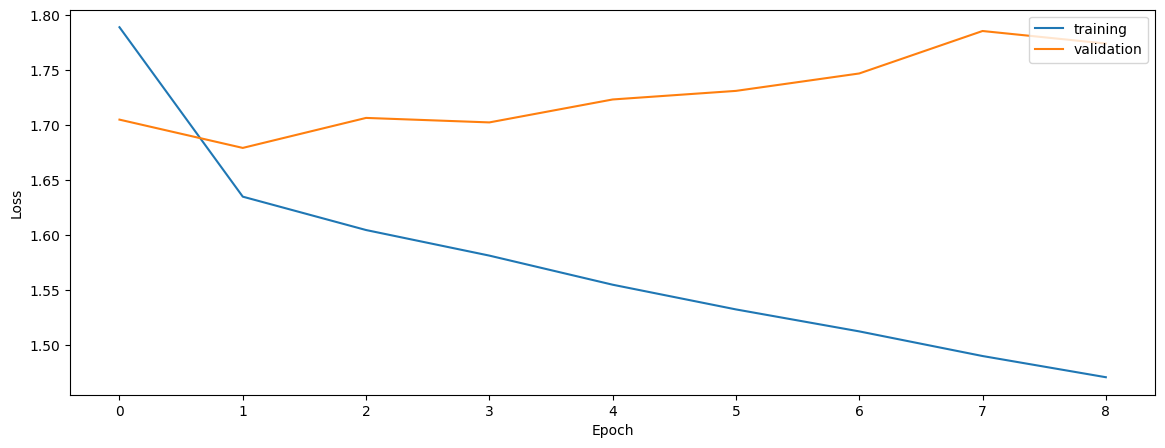

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.3564292835827601
0.33536428276999175
0.3655377465978774


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.4204811446800137
0.4205613938053097
0.4091396327157997


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.41847523222197247
0.4318077183480027
0.4037509825847237


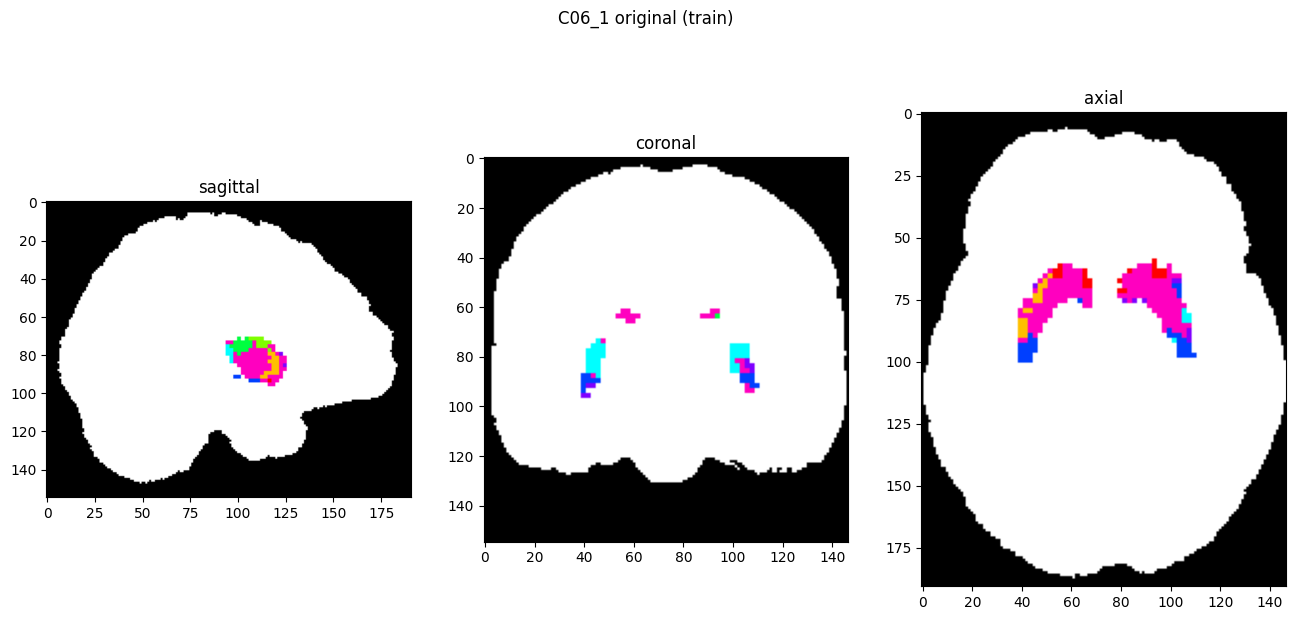

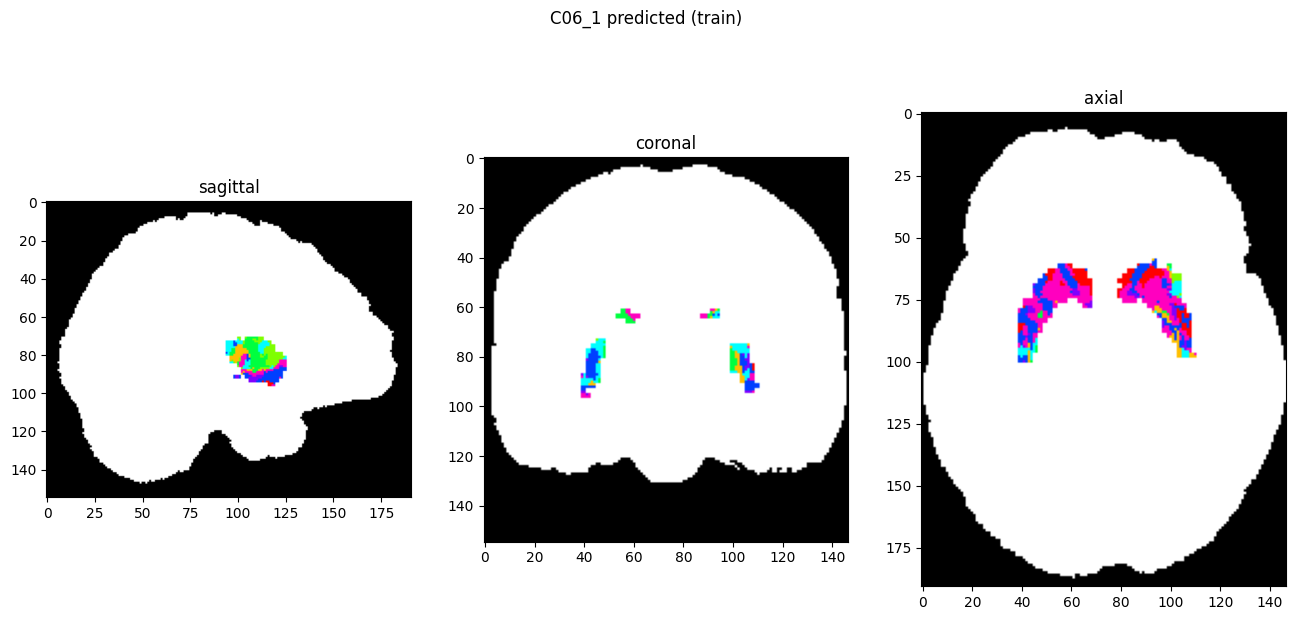

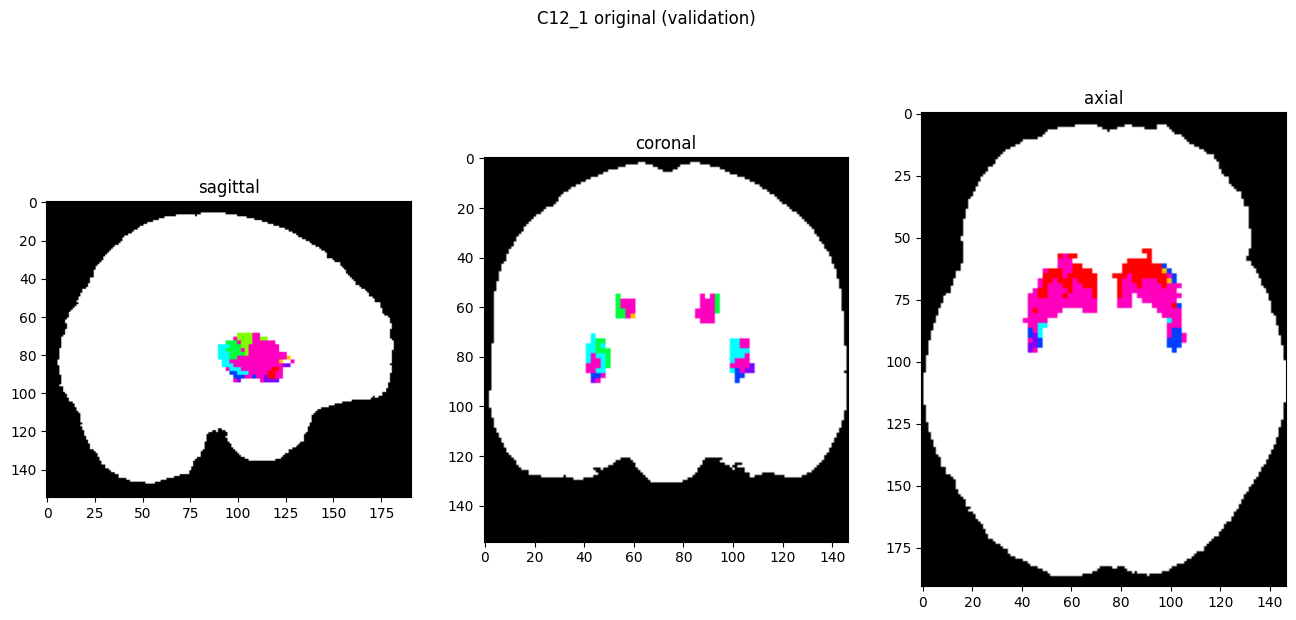

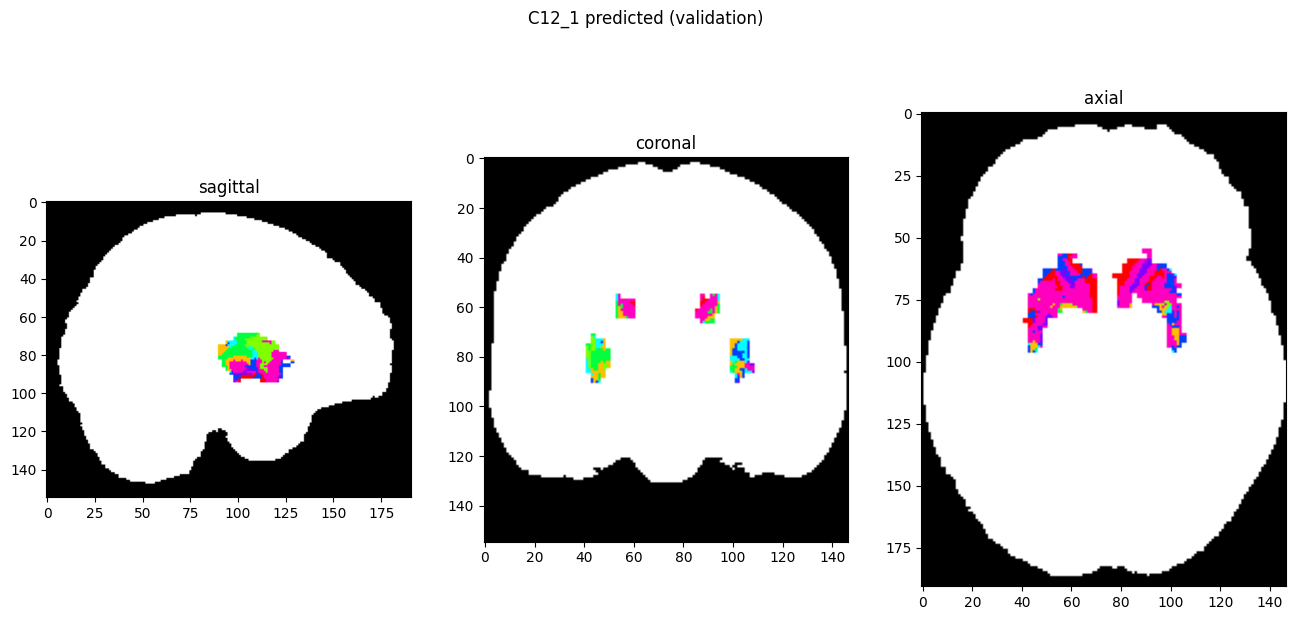

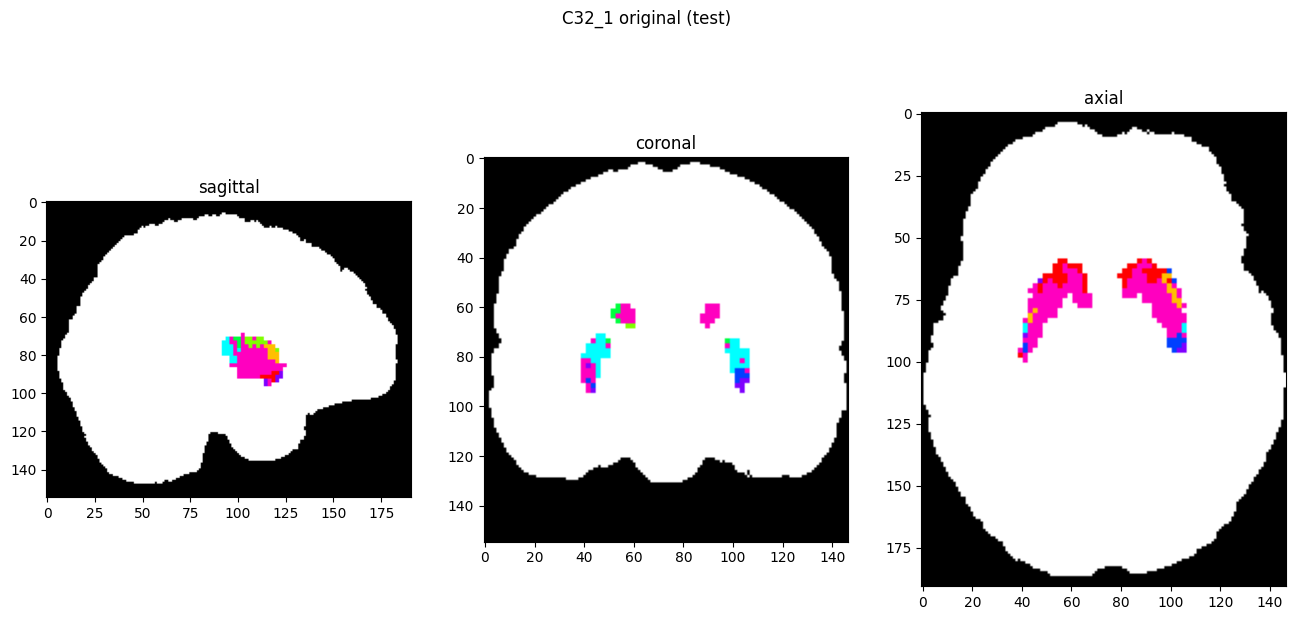

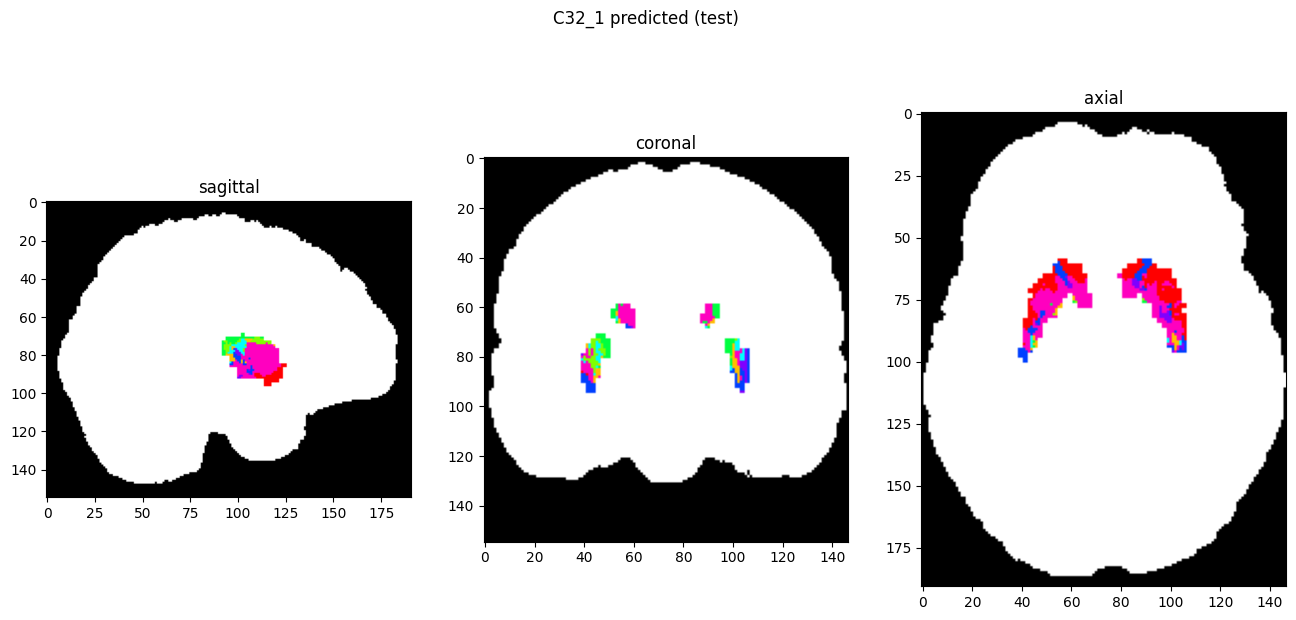

In [10]:
showResults(model, gen, threshold=0)